# Assignment:-

# Applying Logistic Regression on Amazon fine Food Reviews analysis

## Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review

# 1. Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2). Use BoW, TF-IDF, Avg-Word2Vec,TF-IDF-Word2Vec to vectorise the reviews. 
Apply Logistic Regression Algorithm for Amazon fine food Reviews
find right alpha(α) using cross validation
Get feature importance for positive class and Negative class

In [1]:
# loading required libraries 

import warnings 
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd 
import matplotlib 
import sqlite3
import string
import gensim
import scipy 
import nltk
import time
import seaborn as sns 
from scipy import stats
from matplotlib import pyplot as plt 

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as prf1

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split


## 1.1 Connecting SQL file

In [2]:
#Loading the data
con = sqlite3.connect('./final.sqlite')

data = pd.read_sql_query("""
SELECT *
FROM Reviews
""", con)

In [3]:
print(data.shape)
data.head()

(364171, 12)


,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


## 1.2 Data Preprocessing

In [4]:
data.Score.value_counts()
#i had done data preprocessing i had stored in final.sqlite now loaded this file no need to do again data preprocessing


positive    307061
negative     57110
Name: Score, dtype: int64

## 1.3 Sorting the data

In [5]:
# Sorting the data according to the time-stamp
sorted_data = data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
sorted_data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


## 1.4 Mapping

In [6]:
def partition(x):
    if x == 'positive':
        return 1
    return 0

#Preparing the filtered data
actualScore = sorted_data['Score']
positiveNegative = actualScore.map(partition) 
sorted_data['Score'] = positiveNegative
sorted_data.head()


,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


## 1.5 Taking first 150k rows

In [7]:
# We will collect different 150000 rows without repetition from time_sorted_data dataframe
my_final = sorted_data[:150000]
print(my_final.shape)
my_final.head()

(150000, 12)


,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


## 1.6 Spliting data into train and test based on time (70:30)

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate


x=my_final['CleanedText'].values
y=my_final['Score']

#Splitting data into train test and cross validation 
x_train,x_test,y_train,y_test =train_test_split(x,y,test_size =0.3,random_state = 42)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)


(105000,)
(45000,)
(105000,)
(45000,)


## 2.  Techniques For Vectorization

## Why we have to convert text to vector

By converting text to vector we can use whole power of linear algebra.we can find a plane to seperate

Incase of logistic regression to find important features, firstly we have to check multi collinearity between features, if 

features are collinear then we should find important features using forward or backward feature selection.

If features are not correlated then we should use optimal vector, in which consist of weight for each feature.

Multi collinearity: which means very high inter correlation among the independent variables.

## 2.1 BOW

In [9]:
#Bow

from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer() 
final_counts_Bow_tr= count_vect.fit_transform(x_train)# computing Bow
print("the type of count vectorizer ",type(final_counts_Bow_tr))
print("the shape of out text BOW vectorizer ",final_counts_Bow_tr.get_shape())
print("the number of unique words ", final_counts_Bow_tr.get_shape()[1])
final_counts_Bow_test= count_vect.transform(x_test)# computing Bow
print("the type of count vectorizer ",type(final_counts_Bow_test))
print("the shape of out text BOW vectorizer ",final_counts_Bow_test.get_shape())

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (105000, 38300)
the number of unique words  38300
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (45000, 38300)


## 2.1.1 Standardizing Data

In [10]:
# Data-preprocessing: Standardizing the data

from sklearn import preprocessing
standardized_data_train = preprocessing.normalize(final_counts_Bow_tr)
print(standardized_data_train.shape)
standardized_data_test = preprocessing.normalize(final_counts_Bow_test)
print(standardized_data_test.shape)


(105000, 38300)
(45000, 38300)


## 2.2  Applying Logistic Regression Algorithm


## 2.2.1 Gridsearch Cross Validation

## 2.2.1.1Using L1 Regularization


In [11]:
# Finding the best parameters using Grid Seach CV using 2-fold Cross-Validation in Logistic Regression

from sklearn.model_selection import GridSearchCV
tuned_parameters = [{'C': [10**-4,10**-3, 10**-2,10**-1, 1, 10**1,10**2,10**3, 10**4]}]
model = GridSearchCV(LogisticRegression(penalty = 'l1',class_weight='balanced'), tuned_parameters, scoring = 'f1', cv=2, n_jobs=-1)
model.fit(standardized_data_train, y_train)
optimal_C = model.best_estimator_.C
print("The optimal value of C(1/lambda) is : ",model.best_estimator_)
print("\n Accuracy of model using L1 Regularization",model.score(standardized_data_test, y_test))
print(max(model.cv_results_['mean_train_score']))
results = model.cv_results_

The optimal value of C(1/lambda) is :  LogisticRegression(C=10, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

 Accuracy of model using L1 Regularization 0.9360583243695472
0.996879660542493


In [12]:
results['mean_test_score']

array([0.        , 0.        , 0.75729805, 0.89179946, 0.92472537,
       0.93503914, 0.9274081 , 0.91495562, 0.90684966])

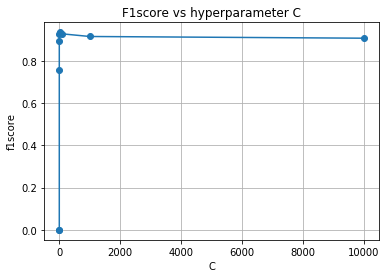

In [13]:
C=10**-4,10**-3, 10**-2,10**-1, 1, 10**1,10**2,10**3, 10**4
plt.plot(C,results['mean_test_score'],marker='o')
plt.xlabel('C')
plt.ylabel('f1score')
plt.title("F1score vs hyperparameter C")
plt.grid()
plt.show()

In [14]:
# Logistic Regression with Optimal value of C(1/lambda)
lr = LogisticRegression(penalty='l1',class_weight='balanced', C=optimal_C, n_jobs=-1)
lr.fit(standardized_data_train,y_train)
pred_bow = lr.predict(standardized_data_test)



## 2.3 Confusion Matrix

Confusion Matrix:


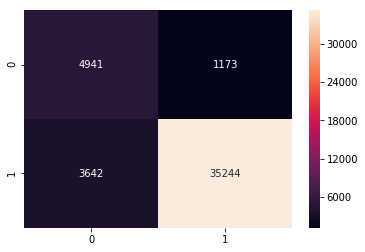

In [15]:
cm_bow=confusion_matrix(y_test,pred_bow)
print("Confusion Matrix:")
sns.heatmap(cm_bow, annot=True, fmt='d')
plt.show()

In [16]:
#finding out  true negative , false positive , false negative and true positve 
tn, fp, fn, tp = cm_bow.ravel()
( tp, fp, fn, tp)
print(" true negitves are {} \n false positives are {} \n false negatives are {}\n true positives are {} \n ".format(tn,fp,fn,tp))

 true negitves are 4941 
 false positives are 1173 
 false negatives are 3642
 true positives are 35244 
 


## 2.4 Calculating Accuracy,Error on test data,Precision,Recall,Classification Report

In [17]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report


# evaluating accuracy
acc_bow = accuracy_score(y_test, pred_bow) * 100
print('\nThe Test Accuracy of the Logistic Regression classifier for C = %.3f is %f%%' % (optimal_C, acc_bow))

# Error on test data
test_error_bow = 100-acc_bow
print("\nTest Error  Logistic Regression classifier is  %f%%" % (test_error_bow))

# evaluating precision
precision_score = precision_score(y_test, pred_bow) 
print('\nThe Test Precision of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, precision_score))

# evaluating recall
recall_score = recall_score(y_test, pred_bow)
print('\nThe Test Recall of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, recall_score))

# evaluating Classification report
classification_report = classification_report(y_test, pred_bow)
print('\nThe Test classification report of the Logistic regression classifier for C \n\n ',(classification_report))


The Test Accuracy of the Logistic Regression classifier for C = 10.000 is 89.300000%

Test Error  Logistic Regression classifier is  10.700000%

The Test Precision of the Logistic Regression classifier for C = 10.000 is 0.967790

The Test Recall of the Logistic Regression classifier for C = 10.000 is 0.906342

The Test classification report of the Logistic regression classifier for C 

                precision    recall  f1-score   support

           0       0.58      0.81      0.67      6114
           1       0.97      0.91      0.94     38886

   micro avg       0.89      0.89      0.89     45000
   macro avg       0.77      0.86      0.80     45000
weighted avg       0.91      0.89      0.90     45000



## 2.5 Perturbation Test

Pertubation test means adding noise to one of the data point and comparing the difference b/w change in previous weights and New 

weights to find of collinearity.

In [18]:
import scipy as sp
epsilon = sp.stats.distributions.norm.rvs(loc=0,scale=0.0001)
# Vector before the addition of epsilon
W_before_epsilon = lr.coef_

# Number of non zero elements in Standardized_train sparse matrix
no_of_non_zero = standardized_data_train.count_nonzero()

# Importing library to create a sparse matrix of epsilon
from scipy.sparse import csr_matrix

# Creating new sparse matrix with epsilon at same position of non-zero elements of standardized_data_train
x_train_indices = standardized_data_train.indices
x_train_indptr = standardized_data_train.indptr #CSR format index pointer array of the matrix

# Creating a list of same element with repetition
data = [epsilon] * no_of_non_zero
Shape = standardized_data_train.shape

# Creating sparse matrix
sparse_epsilon = csr_matrix((data,x_train_indices,x_train_indptr),shape=Shape,dtype=float)

# Add sparse_epsilon and X-standardized_data_train to get a new sparse matrix with epsilon added to each 
# non-zero element of standardized_data_train
epsilon_train = standardized_data_train + sparse_epsilon

print(standardized_data_train.shape)
print(epsilon_train.shape)

(105000, 38300)
(105000, 38300)


In [19]:
# training Logistic Regression Classifier with epsilon_train
epsilon_lr = LogisticRegression(penalty='l2', C=optimal_C, n_jobs=-1)
epsilon_lr.fit(epsilon_train,y_train)

# Vector after the addition of epsilon
W_after_epsilon = epsilon_lr.coef_

# Change in vectors after adding epsilon
change_vector = W_after_epsilon - W_before_epsilon
print("change_vector",change_vector)


# Sort this change_vector array after making all the elements positive in ascending order to visualize the change
sorted_change_vector = np.sort(np.absolute(change_vector))[:,::-1]

sorted_change_vector[0,0:20]

change_vector [[-0.18781211  0.00265793  0.00070282 ...  0.07048499  0.00299014
   0.02426568]]


array([80.43612764, 68.34999415, 63.4533719 , 62.68917174, 61.85769023,
       56.74514478, 48.18468263, 47.03514429, 47.00297897, 45.78555971,
       45.6641654 , 45.55103298, 43.45110589, 42.32678207, 42.15837555,
       41.30281974, 40.21503871, 40.0757641 , 39.52849034, 39.40952553])

In [20]:
absolute_weights = np.absolute(W_before_epsilon)
sorted_absolute_index = np.argsort(absolute_weights)[:,::-1]
top_index = sorted_absolute_index[0,0:20]

all_features = count_vect.get_feature_names()
weight_values = lr.coef_

# Top 20 features are    
print("Top 20 features with their weight values :")

for j in top_index:
    print("%12s\t===> \t%f"%(all_features[j],weight_values[0,j]))

Top 20 features with their weight values :
   mozzerela	===> 	-81.220233
    sonewher	===> 	-69.030073
          ov	===> 	-64.114649
     devault	===> 	-63.687379
yadayadayada	===> 	-63.630917
       dcide	===> 	-57.960560
       gould	===> 	-50.024412
     disastr	===> 	-49.415678
     conceal	===> 	48.887351
     cucazza	===> 	-47.652274
     goodwil	===> 	-46.439456
    distrust	===> 	-45.965285
  robitussin	===> 	-45.469665
        coil	===> 	-44.417156
     differr	===> 	-43.396825
        lvoe	===> 	-42.349713
         yap	===> 	-42.058078
       sheat	===> 	-40.935986
   valentina	===> 	-40.831091
    allrecip	===> 	-40.804848


## 3 Using L2 Regularization


In [21]:
# Finding the best parameters using Grid Seach CV using 2-fold Cross-Validation in Logistic Regression

from sklearn.model_selection import GridSearchCV
tuned_parameters = [{'C': [10**-4,10**-3, 10**-2,10**-1, 1, 10**1,10**2,10**3, 10**4]}]
model = GridSearchCV(LogisticRegression(penalty = 'l2',class_weight='balanced'), tuned_parameters, scoring = 'f1', cv=2, n_jobs=-1)
model.fit(standardized_data_train, y_train)
print("The optimal value of C(1/lambda) is : ",model.best_estimator_)
optimal_C = model.best_estimator_.C
print("\n Accuracy of model using L2 Regularization",model.score(standardized_data_test, y_test))

The optimal value of C(1/lambda) is :  LogisticRegression(C=100, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

 Accuracy of model using L2 Regularization 0.9360330117956134


In [22]:
model.best_params_
results = model.cv_results_
results['mean_test_score']


array([0.84218935, 0.84578152, 0.86785172, 0.90223424, 0.92435706,
       0.93339376, 0.93529618, 0.93061559, 0.92453348])

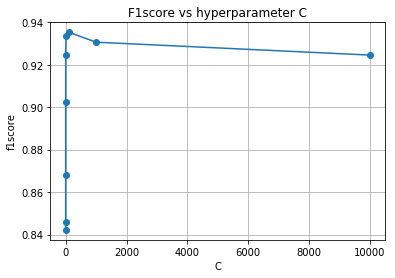

In [23]:
C=10**-4,10**-3, 10**-2,10**-1, 1, 10**1,10**2,10**3, 10**4
plt.plot(C,results['mean_test_score'],marker='o')
plt.xlabel('C')
plt.ylabel('f1score')
plt.title("F1score vs hyperparameter C")
plt.grid()
plt.show()

In [24]:
# Logistic Regression with Optimal value of C(1/lambda)
lr = LogisticRegression(penalty='l1', C=optimal_C, class_weight='balanced',n_jobs=-1)
lr.fit(standardized_data_train,y_train)
pred_bow = lr.predict(standardized_data_test)

## 3.1 Confusion Matrix

Confusion Matrix:


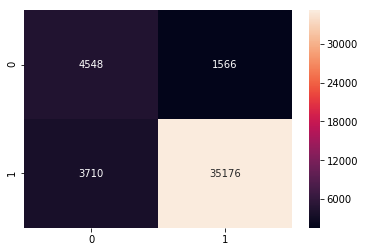

In [25]:
cm_bow=confusion_matrix(y_test,pred_bow)
print("Confusion Matrix:")
sns.heatmap(cm_bow, annot=True, fmt='d')
plt.show()

In [26]:
#finding out  true negative , false positive , false negative and true positve 
tn, fp, fn, tp = cm_bow.ravel()
( tp, fp, fn, tp)
print(" true negitves are {} \n false positives are {} \n false negatives are {}\n true positives are {} \n ".format(tn,fp,fn,tp))

 true negitves are 4548 
 false positives are 1566 
 false negatives are 3710
 true positives are 35176 
 


## 3.2 Calculating Accuracy,Error on test data,Precision,Recall,Classification Report


In [27]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report


# evaluating accuracy
acc_bow = accuracy_score(y_test, pred_bow) * 100
print('\nThe Test Accuracy of the Logistic Regression classifier for C = %.3f is %f%%' % (optimal_C, acc_bow))

# Error on test data
test_error_bow = 100-acc_bow
print("\nTest Error  Logistic Regression classifier is  %f%%" % (test_error_bow))

# evaluating precision
precision_score = precision_score(y_test, pred_bow) 
print('\nThe Test Precision of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, precision_score))

# evaluating recall
recall_score = recall_score(y_test, pred_bow)
print('\nThe Test Recall of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, recall_score))

# evaluating Classification report
classification_report = classification_report(y_test, pred_bow)
print('\nThe Test classification report of the Logistic regression classifier for C \n\n ',(classification_report))


The Test Accuracy of the Logistic Regression classifier for C = 100.000 is 88.275556%

Test Error  Logistic Regression classifier is  11.724444%

The Test Precision of the Logistic Regression classifier for C = 100.000 is 0.957378

The Test Recall of the Logistic Regression classifier for C = 100.000 is 0.904593

The Test classification report of the Logistic regression classifier for C 

                precision    recall  f1-score   support

           0       0.55      0.74      0.63      6114
           1       0.96      0.90      0.93     38886

   micro avg       0.88      0.88      0.88     45000
   macro avg       0.75      0.82      0.78     45000
weighted avg       0.90      0.88      0.89     45000



## 3.3 Perturbation Test

Pertubation test means adding noise to one of the data point and comparing the difference b/w change in previous weights and New 

weights to find of collinearity.

In [28]:
import scipy as sp
epsilon = sp.stats.distributions.norm.rvs(loc=0,scale=0.0001)
# Vector before the addition of epsilon
W_before_epsilon = lr.coef_

# Number of non zero elements in Standardized_train sparse matrix
no_of_non_zero = standardized_data_train.count_nonzero()

# Importing library to create a sparse matrix of epsilon
from scipy.sparse import csr_matrix

# Creating new sparse matrix with epsilon at same position of non-zero elements of standardized_data_train
x_train_indices = standardized_data_train.indices
x_train_indptr = standardized_data_train.indptr #CSR format index pointer array of the matrix

# Creating a list of same element with repetition
data = [epsilon] * no_of_non_zero
Shape = standardized_data_train.shape

# Creating sparse matrix
sparse_epsilon = csr_matrix((data,x_train_indices,x_train_indptr),shape=Shape,dtype=float)

# Add sparse_epsilon and X-standardized_data_train to get a new sparse matrix with epsilon added to each 
# non-zero element of standardized_data_train
epsilon_train = standardized_data_train + sparse_epsilon

print(standardized_data_train.shape)
print(epsilon_train.shape)

(105000, 38300)
(105000, 38300)


In [29]:
# training Logistic Regression Classifier with epsilon_train
epsilon_lr = LogisticRegression(penalty='l2', C=optimal_C, n_jobs=-1)
epsilon_lr.fit(epsilon_train,y_train)

# Vector after the addition of epsilon
W_after_epsilon = epsilon_lr.coef_

# Change in vectors after adding epsilon
change_vector = W_after_epsilon - W_before_epsilon
print("change_vector",change_vector)


# Sort this change_vector array after making all the elements positive in ascending order to visualize the change
sorted_change_vector = np.sort(np.absolute(change_vector))[:,::-1]

sorted_change_vector[0,0:20]

change_vector [[-0.38546745  0.0133082   0.00260297 ...  0.52743074  0.01591668
   0.20440039]]


array([279.89737901, 244.93824374, 243.28154387, 224.69960439,
       213.30730546, 184.82155136, 182.28277033, 174.96124204,
       171.70893446, 169.22951164, 162.74209369, 161.06205587,
       158.43263579, 157.2051283 , 156.50838444, 154.91301797,
       152.62204688, 151.55942332, 150.21767536, 149.83455957])

In [30]:
absolute_weights = np.absolute(W_before_epsilon)
sorted_absolute_index = np.argsort(absolute_weights)[:,::-1]
top_index = sorted_absolute_index[0,0:20]

all_features = count_vect.get_feature_names()
weight_values = lr.coef_

# Top 20 features are    
print("Top 20 features with their weight values :")

for j in top_index:
    print("%12s\t===> \t%f"%(all_features[j],weight_values[0,j]))

Top 20 features with their weight values :
     fishier	===> 	-285.214412
      corect	===> 	-251.279729
      reclin	===> 	243.825402
     uninari	===> 	-237.050619
    advantix	===> 	-218.687210
      conlus	===> 	-188.170532
        poem	===> 	185.470745
     jivalim	===> 	-179.065145
     goodwil	===> 	-177.997433
    sonewher	===> 	-176.043247
   mozzerela	===> 	-170.576943
        ridx	===> 	-168.161849
       anywh	===> 	-164.032482
      glimps	===> 	-161.199524
    crosswis	===> 	-161.000928
     hermosa	===> 	-157.407477
 opportunist	===> 	-156.843131
   grainiest	===> 	-156.185795
  settlement	===> 	155.093561
     colicki	===> 	154.797667


## 4 Randomized Search Cross Validation


## 4.1 Using L1 Regularization


In [31]:
# Finding the best parameters using Random Seach CV using 2-fold Cross-Validation in Logistic Regression

from sklearn.model_selection import RandomizedSearchCV
param_distributions = {'C': [10**-4,10**-3, 10**-2,10**-1, 1, 10**1,10**2,10**3, 10**4]}
model = RandomizedSearchCV(LogisticRegression(penalty = 'l1',class_weight='balanced'), param_distributions, scoring = 'f1',cv=2, n_iter=4, n_jobs=-1,pre_dispatch=2)
model.fit(standardized_data_train, y_train)
print("The optimal value of C(1/lambda) is : ",model.best_estimator_)
optimal_C = model.best_estimator_.C
print("\n Accuracy of model using L1 Regularization",model.score(standardized_data_test, y_test))

The optimal value of C(1/lambda) is :  LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

 Accuracy of model using L1 Regularization 0.9287322234953158


In [32]:
model.best_params_
results = model.cv_results_
results['mean_test_score']


array([0.89179946, 0.92473161, 0.75729805, 0.        ])

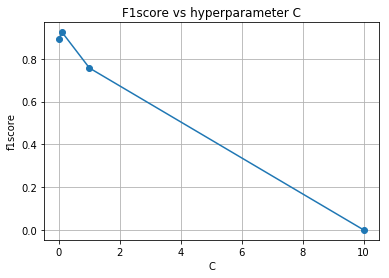

In [33]:
C= 10**-2,10**-1, 1, 10**1,
plt.plot(C,results['mean_test_score'],marker='o')
plt.xlabel('C')
plt.ylabel('f1score')
plt.title("F1score vs hyperparameter C")
plt.grid()
plt.show()

In [34]:
# Logistic Regression with Optimal value of C(1/lambda)
lr = LogisticRegression(penalty='l1', C=optimal_C,class_weight='balanced', n_jobs=-1)
lr.fit(standardized_data_train,y_train)
pred_bow = lr.predict(standardized_data_test)



## 4.2 Confusion Matrix

Confusion Matrix:


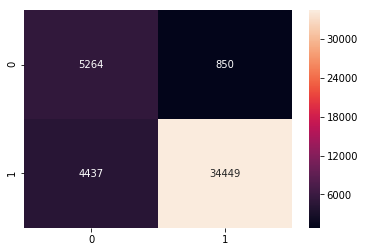

In [35]:
cm_bow=confusion_matrix(y_test,pred_bow)
print("Confusion Matrix:")
sns.heatmap(cm_bow, annot=True, fmt='d')
plt.show()

In [36]:
#finding out  true negative , false positive , false negative and true positve 
tn, fp, fn, tp = cm_bow.ravel()
( tp, fp, fn, tp)
print(" true negitves are {} \n false positives are {} \n false negatives are {}\n true positives are {} \n ".format(tn,fp,fn,tp))

 true negitves are 5264 
 false positives are 850 
 false negatives are 4437
 true positives are 34449 
 


## 4.3 Calculating Accuracy,Error on test data,Precision,Recall,Classification Report

In [37]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report


# evaluating accuracy
acc_bow = accuracy_score(y_test, pred_bow) * 100
print('\nThe Test Accuracy of the Logistic Regression classifier for C = %.3f is %f%%' % (optimal_C, acc_bow))

# Error on test data
test_error_bow = 100-acc_bow
print("\nTest Error  Logistic Regression classifier is  %f%%" % (test_error_bow))

# evaluating precision
precision_score = precision_score(y_test, pred_bow) 
print('\nThe Test Precision of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, precision_score))

# evaluating recall
recall_score = recall_score(y_test, pred_bow)
print('\nThe Test Recall of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, recall_score))

# evaluating Classification report
classification_report = classification_report(y_test, pred_bow)
print('\nThe Test classification report of the Logistic regression classifier for C \n\n ',(classification_report))


The Test Accuracy of the Logistic Regression classifier for C = 1.000 is 88.251111%

Test Error  Logistic Regression classifier is  11.748889%

The Test Precision of the Logistic Regression classifier for C = 1.000 is 0.975920

The Test Recall of the Logistic Regression classifier for C = 1.000 is 0.885897

The Test classification report of the Logistic regression classifier for C 

                precision    recall  f1-score   support

           0       0.54      0.86      0.67      6114
           1       0.98      0.89      0.93     38886

   micro avg       0.88      0.88      0.88     45000
   macro avg       0.76      0.87      0.80     45000
weighted avg       0.92      0.88      0.89     45000



## 4.4 Perturbation Test

Pertubation test means adding noise to one of the data point and comparing the difference b/w change in previous weights and New 

weights to find of collinearity.

In [38]:
import scipy as sp
epsilon = sp.stats.distributions.norm.rvs(loc=0,scale=0.0001)
# Vector before the addition of epsilon
W_before_epsilon = lr.coef_

# Number of non zero elements in Standardized_train sparse matrix
no_of_non_zero = standardized_data_train.count_nonzero()

# Importing library to create a sparse matrix of epsilon
from scipy.sparse import csr_matrix

# Creating new sparse matrix with epsilon at same position of non-zero elements of standardized_data_train
x_train_indices = standardized_data_train.indices
x_train_indptr = standardized_data_train.indptr #CSR format index pointer array of the matrix

# Creating a list of same element with repetition
data = [epsilon] * no_of_non_zero
Shape = standardized_data_train.shape

# Creating sparse matrix
sparse_epsilon = csr_matrix((data,x_train_indices,x_train_indptr),shape=Shape,dtype=float)

# Add sparse_epsilon and X-standardized_data_train to get a new sparse matrix with epsilon added to each 
# non-zero element of standardized_data_train
epsilon_train = standardized_data_train + sparse_epsilon

print(standardized_data_train.shape)
print(epsilon_train.shape)

(105000, 38300)
(105000, 38300)


In [39]:
# training Logistic Regression Classifier with epsilon_train
epsilon_lr = LogisticRegression(penalty='l2', C=optimal_C, n_jobs=-1)
epsilon_lr.fit(epsilon_train,y_train)

# Vector after the addition of epsilon
W_after_epsilon = epsilon_lr.coef_

# Change in vectors after adding epsilon
change_vector = W_after_epsilon - W_before_epsilon
print("change_vector",change_vector)


# Sort this change_vector array after making all the elements positive in ascending order to visualize the change
sorted_change_vector = np.sort(np.absolute(change_vector))[:,::-1]

sorted_change_vector[0,0:20]

change_vector [[-0.03672996  0.00054887  0.00033181 ...  0.00673288  0.0009489
   0.00268351]]


array([11.95219371, 10.0082331 ,  9.76158746,  9.25378138,  8.45149723,
        7.9692281 ,  7.78368559,  7.34347925,  7.22232061,  7.11104477,
        7.06928   ,  6.66598343,  6.65607234,  6.50565939,  6.48649745,
        6.20296582,  6.13102896,  6.10131871,  6.0579145 ,  5.99302139])

In [40]:
absolute_weights = np.absolute(W_before_epsilon)
sorted_absolute_index = np.argsort(absolute_weights)[:,::-1]
top_index = sorted_absolute_index[0,0:20]

all_features = count_vect.get_feature_names()
weight_values = lr.coef_

# Top 20 features are    
print("Top 20 features with their weight values :")

for j in top_index:
    print("%12s\t===> \t%f"%(all_features[j],weight_values[0,j]))

Top 20 features with their weight values :
       worst	===> 	-19.582215
     mediocr	===> 	-14.076660
     skeptic	===> 	12.650783
     terribl	===> 	-12.614439
   disapoint	===> 	-11.710660
     horribl	===> 	-11.327022
     useless	===> 	-10.671762
        hook	===> 	10.571999
     disgust	===> 	-10.505307
  flavorless	===> 	-10.478674
   tasteless	===> 	-10.410308
          aw	===> 	-10.144832
        beat	===> 	9.987876
     downsid	===> 	9.786155
        amaz	===> 	9.735837
       broke	===> 	-9.720780
      deceiv	===> 	-9.675675
  disappoint	===> 	-9.637756
     unpleas	===> 	-9.601158
       uniqu	===> 	9.594695


## 5. Using L2 Regularization


In [41]:

# Finding the best parameters using Random Seach CV using 2-fold Cross-Validation in Logistic Regression

from sklearn.model_selection import RandomizedSearchCV
param_distributions = {'C': [10**-4,10**-3, 10**-2,10**-1, 1, 10**1,10**2,10**3, 10**4]}
model = RandomizedSearchCV(LogisticRegression(penalty = 'l2',class_weight='balanced'), param_distributions, scoring = 'f1',cv=2, n_iter=4, n_jobs=-1,pre_dispatch=2)
model.fit(standardized_data_train, y_train)
print("The optimal value of C(1/lambda) is : ",model.best_estimator_)
optimal_C = model.best_estimator_.C
print("\n Accuracy of model using L2 Regularization",model.score(standardized_data_test, y_test))


The optimal value of C(1/lambda) is :  LogisticRegression(C=10, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

 Accuracy of model using L2 Regularization 0.9344472664082342


In [42]:
model.best_params_
results = model.cv_results_
results['mean_test_score']


array([0.90223424, 0.92453348, 0.93339376, 0.93061559])

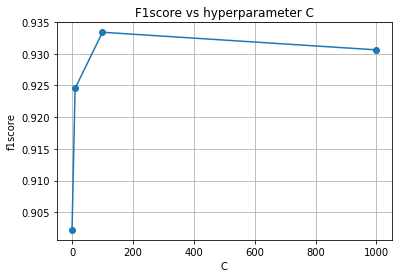

In [43]:
C= 10**-2,10**1,10**2,10**3
plt.plot(C,results['mean_test_score'],marker='o')
plt.xlabel('C')
plt.ylabel('f1score')
plt.title("F1score vs hyperparameter C")
plt.grid()
plt.show()

In [44]:
# Logistic Regression with Optimal value of C(1/lambda)
lr = LogisticRegression(penalty='l2',class_weight='balanced', C=optimal_C, n_jobs=-1)
lr.fit(standardized_data_train,y_train)
pred_bow = lr.predict(standardized_data_test)

## 5.1 Confusion Matrix

Confusion Matrix:


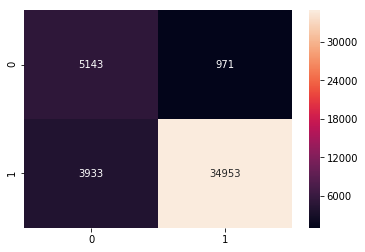

In [45]:
cm_bow=confusion_matrix(y_test,pred_bow)
print("Confusion Matrix:")
sns.heatmap(cm_bow, annot=True, fmt='d')
plt.show()

In [46]:
#finding out  true negative , false positive , false negative and true positve 
tn, fp, fn, tp = cm_bow.ravel()
( tp, fp, fn, tp)
print(" true negitves are {} \n false positives are {} \n false negatives are {}\n true positives are {} \n ".format(tn,fp,fn,tp))

 true negitves are 5143 
 false positives are 971 
 false negatives are 3933
 true positives are 34953 
 


## 5.2 Calculating Accuracy,Error on test data,Precision,Recall,Classification Report

In [47]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report


# evaluating accuracy
acc_bow = accuracy_score(y_test, pred_bow) * 100
print('\nThe Test Accuracy of the Logistic Regression classifier for C = %.3f is %f%%' % (optimal_C, acc_bow))

# Error on test data
test_error_bow = 100-acc_bow
print("\nTest Error  Logistic Regression classifier is  %f%%" % (test_error_bow))

# evaluating precision
precision_score = precision_score(y_test, pred_bow) 
print('\nThe Test Precision of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, precision_score))

# evaluating recall
recall_score = recall_score(y_test, pred_bow)
print('\nThe Test Recall of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, recall_score))

# evaluating Classification report
classification_report = classification_report(y_test, pred_bow)
print('\nThe Test classification report of the Logistic regression classifier for C \n\n ',(classification_report))


The Test Accuracy of the Logistic Regression classifier for C = 10.000 is 89.102222%

Test Error  Logistic Regression classifier is  10.897778%

The Test Precision of the Logistic Regression classifier for C = 10.000 is 0.972971

The Test Recall of the Logistic Regression classifier for C = 10.000 is 0.898858

The Test classification report of the Logistic regression classifier for C 

                precision    recall  f1-score   support

           0       0.57      0.84      0.68      6114
           1       0.97      0.90      0.93     38886

   micro avg       0.89      0.89      0.89     45000
   macro avg       0.77      0.87      0.81     45000
weighted avg       0.92      0.89      0.90     45000



## 5.3 Perturbation Test

Pertubation test means adding noise to one of the data point and comparing the difference b/w change in previous weights and New 

weights to find of collinearity.

In [48]:
import scipy as sp
epsilon = sp.stats.distributions.norm.rvs(loc=0,scale=0.0001)
# Vector before the addition of epsilon
W_before_epsilon = lr.coef_

# Number of non zero elements in Standardized_train sparse matrix
no_of_non_zero = standardized_data_train.count_nonzero()

# Importing library to create a sparse matrix of epsilon
from scipy.sparse import csr_matrix

# Creating new sparse matrix with epsilon at same position of non-zero elements of standardized_data_train
x_train_indices = standardized_data_train.indices
x_train_indptr = standardized_data_train.indptr #CSR format index pointer array of the matrix

# Creating a list of same element with repetition
data = [epsilon] * no_of_non_zero
Shape = standardized_data_train.shape

# Creating sparse matrix
sparse_epsilon = csr_matrix((data,x_train_indices,x_train_indptr),shape=Shape,dtype=float)

# Add sparse_epsilon and X-standardized_data_train to get a new sparse matrix with epsilon added to each 
# non-zero element of standardized_data_train
epsilon_train = standardized_data_train + sparse_epsilon

print(standardized_data_train.shape)
print(epsilon_train.shape)

(105000, 38300)
(105000, 38300)


In [49]:
# training Logistic Regression Classifier with epsilon_train
epsilon_lr = LogisticRegression(penalty='l2', C=optimal_C, n_jobs=-1)
epsilon_lr.fit(epsilon_train,y_train)

# Vector after the addition of epsilon
W_after_epsilon = epsilon_lr.coef_

# Change in vectors after adding epsilon
change_vector = W_after_epsilon - W_before_epsilon
print("change_vector",change_vector)


# Sort this change_vector array after making all the elements positive in ascending order to visualize the change
sorted_change_vector = np.sort(np.absolute(change_vector))[:,::-1]

sorted_change_vector[0,0:20]

change_vector [[ 0.01054712 -0.00348103 -0.00072059 ... -0.01447428 -0.00601319
  -0.04338689]]


array([5.99059881, 5.50707802, 5.47037243, 5.35516691, 4.94093859,
       4.69522282, 4.68573963, 4.62902979, 4.56943911, 4.46549101,
       4.38718433, 4.335611  , 4.32770104, 4.27473725, 4.26287705,
       4.1774262 , 4.16278218, 4.1283014 , 4.12705468, 4.10878494])

In [50]:
absolute_weights = np.absolute(W_before_epsilon)
sorted_absolute_index = np.argsort(absolute_weights)[:,::-1]
top_index = sorted_absolute_index[0,0:20]

all_features = count_vect.get_feature_names()
weight_values = lr.coef_

# Top 20 features are    
print("Top 20 features with their weight values :")

for j in top_index:
    print("%12s\t===> \t%f"%(all_features[j],weight_values[0,j]))

Top 20 features with their weight values :
       worst	===> 	-18.771736
     terribl	===> 	-12.983687
     mediocr	===> 	-12.628431
     skeptic	===> 	11.907594
     horribl	===> 	-11.429740
   disapoint	===> 	-11.296132
     concept	===> 	-11.143636
        hook	===> 	10.959550
     disgust	===> 	-10.506773
        beat	===> 	10.491044
   tasteless	===> 	-10.346076
          aw	===> 	-10.191086
        amaz	===> 	10.184085
  disappoint	===> 	-10.070497
  flavorless	===> 	-9.961854
       threw	===> 	-9.892857
      delici	===> 	9.715198
       broke	===> 	-9.606893
     downsid	===> 	9.535177
     unpleas	===> 	-9.490418


## 6. TF-IDF

In [51]:
#tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer()

final_counts_tfidf_tr= tf_idf_vect.fit_transform(x_train)
print("the type of count vectorizer ",type(final_counts_tfidf_tr))
print("the shape of out text tfidf vectorizer ",final_counts_tfidf_tr.get_shape())
print("the number of unique words ", final_counts_tfidf_tr.get_shape()[1])
final_counts_tfidf_test= tf_idf_vect.transform(x_test)
print("the type of count vectorizer ",type(final_counts_tfidf_test))
print("the shape of out text tfidf vectorizer ",final_counts_tfidf_test.get_shape())
print("the number of unique words ", final_counts_tfidf_test.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text tfidf vectorizer  (105000, 38300)
the number of unique words  38300
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text tfidf vectorizer  (45000, 38300)
the number of unique words  38300


## 6.1 Standardizing Data

In [52]:
# Data-preprocessing: Standardizing the data
from sklearn import preprocessing
standardized_data_train = preprocessing.normalize(final_counts_tfidf_tr)
print(standardized_data_train.shape)
standardized_data_test = preprocessing.normalize(final_counts_tfidf_test)
print(standardized_data_test.shape)


(105000, 38300)
(45000, 38300)


## 6.2 Applying Logistic Regression Algorithm


## 6.2.1 Gridsearch Cross Validation

## 6.2.1.1 Using L1 Regularization


In [53]:
# Finding the best parameters using Grid Seach CV using 2-fold Cross-Validation in Logistic Regression

from sklearn.model_selection import GridSearchCV
tuned_parameters = [{'C': [10**-4,10**-3, 10**-2,10**-1, 1, 10**1,10**2,10**3, 10**4]}]
model = GridSearchCV(LogisticRegression(penalty = 'l1',class_weight='balanced'), tuned_parameters, scoring = 'f1', cv=2, n_jobs=-1)
model.fit(standardized_data_train, y_train)
print("The optimal value of C(1/lambda) is : ",model.best_estimator_)
optimal_C = model.best_estimator_.C
print("\n Accuracy of model using L1 Regularization",model.score(standardized_data_test, y_test))

The optimal value of C(1/lambda) is :  LogisticRegression(C=10, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

 Accuracy of model using L1 Regularization 0.9351884979791957


In [54]:
model.best_params_
results = model.cv_results_
results['mean_test_score']


array([0.        , 0.        , 0.70993004, 0.893637  , 0.92683598,
       0.93496381, 0.92388628, 0.91156309, 0.90634564])

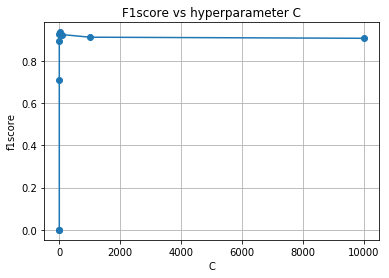

In [55]:
C=10**-4,10**-3, 10**-2,10**-1, 1, 10**1,10**2,10**3, 10**4
plt.plot(C,results['mean_test_score'],marker='o')
plt.xlabel('C')
plt.ylabel('f1score')
plt.title("F1score vs hyperparameter C")
plt.grid()
plt.show()

In [56]:
# Logistic Regression with Optimal value of C(1/lambda)
lr = LogisticRegression(penalty='l1', class_weight='balanced',C=optimal_C, n_jobs=-1)
lr.fit(standardized_data_train,y_train)
pred_tfidf = lr.predict(standardized_data_test)

## 6.3 Confusion Matrix

Confusion Matrix:


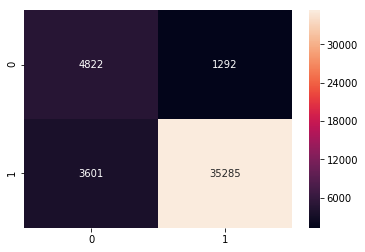

In [57]:
cm_tfidf=confusion_matrix(y_test,pred_tfidf)
print("Confusion Matrix:")
sns.heatmap(cm_tfidf, annot=True, fmt='d')
plt.show()

In [58]:
#finding out  true negative , false positive , false negative and true positve 
tn, fp, fn, tp = cm_tfidf.ravel()
( tp, fp, fn, tp)
print(" true negitves are {} \n false positives are {} \n false negatives are {}\n true positives are {} \n ".format(tn,fp,fn,tp))

 true negitves are 4822 
 false positives are 1292 
 false negatives are 3601
 true positives are 35285 
 


## 6.4 Calculating Accuracy,Error on test data,Precision,Recall,Classification Report

In [59]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report


# evaluating accuracy
acc_tfidf = accuracy_score(y_test, pred_tfidf) * 100
print('\nThe Test Accuracy of the Logistic Regression classifier for C = %.3f is %f%%' % (optimal_C, acc_tfidf))

# Error on test data
test_error_tfidf = 100-acc_tfidf
print("\nTest Error  Logistic Regression classifier is  %f%%" % (test_error_tfidf))

# evaluating precision
precision_score = precision_score(y_test, pred_tfidf) 
print('\nThe Test Precision of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, precision_score))

# evaluating recall
recall_score = recall_score(y_test, pred_tfidf)
print('\nThe Test Recall of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, recall_score))

# evaluating Classification report
classification_report = classification_report(y_test, pred_tfidf)
print('\nThe Test classification report of the Logistic regression classifier for C \n\n ',(classification_report))


The Test Accuracy of the Logistic Regression classifier for C = 10.000 is 89.126667%

Test Error  Logistic Regression classifier is  10.873333%

The Test Precision of the Logistic Regression classifier for C = 10.000 is 0.964677

The Test Recall of the Logistic Regression classifier for C = 10.000 is 0.907396

The Test classification report of the Logistic regression classifier for C 

                precision    recall  f1-score   support

           0       0.57      0.79      0.66      6114
           1       0.96      0.91      0.94     38886

   micro avg       0.89      0.89      0.89     45000
   macro avg       0.77      0.85      0.80     45000
weighted avg       0.91      0.89      0.90     45000



## 6.5 Perturbation Test

Pertubation test means adding noise to one of the data point and comparing the difference b/w change in previous weights and New 

weights to find of collinearity.

In [60]:
import scipy as sp
epsilon = sp.stats.distributions.norm.rvs(loc=0,scale=0.0001)
# Vector before the addition of epsilon
W_before_epsilon = lr.coef_

# Number of non zero elements in Standardized_train sparse matrix
no_of_non_zero = standardized_data_train.count_nonzero()

# Importing library to create a sparse matrix of epsilon
from scipy.sparse import csr_matrix

# Creating new sparse matrix with epsilon at same position of non-zero elements of standardized_data_train
x_train_indices = standardized_data_train.indices
x_train_indptr = standardized_data_train.indptr #CSR format index pointer array of the matrix

# Creating a list of same element with repetition
data = [epsilon] * no_of_non_zero
Shape = standardized_data_train.shape

# Creating sparse matrix
sparse_epsilon = csr_matrix((data,x_train_indices,x_train_indptr),shape=Shape,dtype=float)

# Add sparse_epsilon and X-standardized_data_train to get a new sparse matrix with epsilon added to each 
# non-zero element of standardized_data_train
epsilon_train = standardized_data_train + sparse_epsilon

print(standardized_data_train.shape)
print(epsilon_train.shape)

(105000, 38300)
(105000, 38300)


In [61]:
# training Logistic Regression Classifier with epsilon_train
epsilon_lr = LogisticRegression(penalty='l2', C=optimal_C, n_jobs=-1)
epsilon_lr.fit(epsilon_train,y_train)

# Vector after the addition of epsilon
W_after_epsilon = epsilon_lr.coef_

# Change in vectors after adding epsilon
change_vector = W_after_epsilon - W_before_epsilon
print("change_vector",change_vector)


# Sort this change_vector array after making all the elements positive in ascending order to visualize the change
sorted_change_vector = np.sort(np.absolute(change_vector))[:,::-1]

sorted_change_vector[0,0:20]

change_vector [[-0.27728179  0.00680161  0.0017184  ...  0.17524598  0.00779493
   0.07936795]]


array([47.28059579, 42.82750087, 39.70044163, 38.34530067, 36.99798654,
       35.19641698, 35.06358269, 33.58207186, 32.48653166, 32.02846903,
       31.50426041, 31.1021987 , 30.92176469, 29.27284061, 29.19117597,
       28.75996981, 28.68942139, 28.64270993, 28.5468826 , 28.50683567])

In [62]:
absolute_weights = np.absolute(W_before_epsilon)
sorted_absolute_index = np.argsort(absolute_weights)[:,::-1]
top_index = sorted_absolute_index[0,0:20]

all_features = tf_idf_vect.get_feature_names()
weight_values = lr.coef_

# Top 20 features are    
print("Top 20 features with their weight values :")

for j in top_index:
    print("%12s\t===> \t%f"%(all_features[j],weight_values[0,j]))

Top 20 features with their weight values :
      corect	===> 	-48.871742
   mozzerela	===> 	-44.469358
    sonewher	===> 	-41.609672
     fishier	===> 	-39.331008
     goodwil	===> 	-38.454883
          ov	===> 	-37.042565
     jivalim	===> 	-36.048681
     devault	===> 	-35.922976
yadayadayada	===> 	-35.870203
        ridx	===> 	-33.451772
faeriesfinest	===> 	-32.667537
   grainiest	===> 	-32.595303
    advantix	===> 	-32.031692
   insuffici	===> 	-31.828142
     merritt	===> 	-31.443158
   voluntari	===> 	-31.355717
disstributor	===> 	30.593020
 opportunist	===> 	-30.297799
   pessimist	===> 	-30.115845
       dcide	===> 	-29.952639


## 7. Using L2 Regularization


In [63]:
# Finding the best parameters using Grid Seach CV using 2-fold Cross-Validation in Logistic Regression

from sklearn.model_selection import GridSearchCV
tuned_parameters = [{'C': [10**-4,10**-3, 10**-2,10**-1, 1, 10**1,10**2,10**3, 10**4]}]
model = GridSearchCV(LogisticRegression(penalty = 'l2',class_weight='balanced'), tuned_parameters, scoring = 'f1', cv=2, n_jobs=-1)
model.fit(standardized_data_train, y_train)
print("The optimal value of C(1/lambda) is : ",model.best_estimator_)
optimal_C = model.best_estimator_.C
print("\n Accuracy of model using L2 Regularization",model.score(standardized_data_test, y_test))

The optimal value of C(1/lambda) is :  LogisticRegression(C=10, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

 Accuracy of model using L2 Regularization 0.9363146336594129


In [64]:
model.best_params_
results = model.cv_results_
results['mean_test_score']


array([0.89110448, 0.89003152, 0.89807317, 0.91589431, 0.93000845,
       0.93620371, 0.93377054, 0.926172  , 0.91919104])

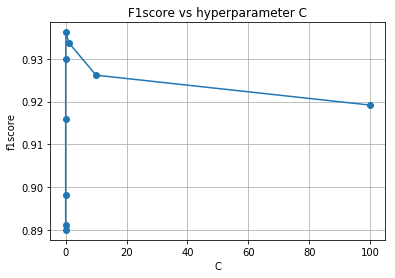

In [65]:
C=10**-6,10**-5,10**-4,10**-3, 10**-2,10**-1, 1, 10**1,10**2
plt.plot(C,results['mean_test_score'],marker='o')
plt.xlabel('C')
plt.ylabel('f1score')
plt.title("F1score vs hyperparameter C")
plt.grid()
plt.show()

In [66]:
# Logistic Regression with Optimal value of C(1/lambda)
lr = LogisticRegression(penalty='l2',class_weight='balanced', C=optimal_C, n_jobs=-1)
lr.fit(standardized_data_train,y_train)
pred_tfidf = lr.predict(standardized_data_test)



## 7.1 Confusion Matrix

Confusion Matrix:


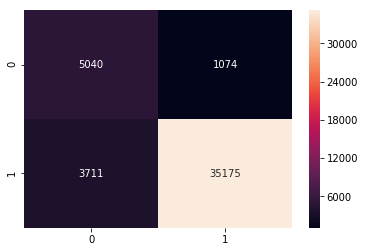

In [67]:
cm_tfidf=confusion_matrix(y_test,pred_tfidf)
print("Confusion Matrix:")
sns.heatmap(cm_tfidf, annot=True, fmt='d')
plt.show()

In [68]:
#finding out  true negative , false positive , false negative and true positve 
tn, fp, fn, tp = cm_tfidf.ravel()
( tp, fp, fn, tp)
print(" true negitves are {} \n false positives are {} \n false negatives are {}\n true positives are {} \n ".format(tn,fp,fn,tp))

 true negitves are 5040 
 false positives are 1074 
 false negatives are 3711
 true positives are 35175 
 


## 7.2 Calculating Accuracy,Error on test data,Precision,Recall,Classification Report

In [69]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report


# evaluating accuracy
acc_tfidf = accuracy_score(y_test, pred_tfidf) * 100
print('\nThe Test Accuracy of the Logistic Regression classifier for C = %.3f is %f%%' % (optimal_C, acc_tfidf))

# Error on test data
test_error_tfidf = 100-acc_tfidf
print("\nTest Error  Logistic Regression classifier is  %f%%" % (test_error_tfidf))

# evaluating precision
precision_score = precision_score(y_test, pred_tfidf) 
print('\nThe Test Precision of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, precision_score))

# evaluating recall
recall_score = recall_score(y_test, pred_tfidf)
print('\nThe Test Recall of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, recall_score))

# evaluating Classification report
classification_report = classification_report(y_test, pred_tfidf)
print('\nThe Test classification report of the Logistic regression classifier for C \n\n ',(classification_report))


The Test Accuracy of the Logistic Regression classifier for C = 10.000 is 89.366667%

Test Error  Logistic Regression classifier is  10.633333%

The Test Precision of the Logistic Regression classifier for C = 10.000 is 0.970372

The Test Recall of the Logistic Regression classifier for C = 10.000 is 0.904567

The Test classification report of the Logistic regression classifier for C 

                precision    recall  f1-score   support

           0       0.58      0.82      0.68      6114
           1       0.97      0.90      0.94     38886

   micro avg       0.89      0.89      0.89     45000
   macro avg       0.77      0.86      0.81     45000
weighted avg       0.92      0.89      0.90     45000



## 7.3 Perturbation Test

Pertubation test means adding noise to one of the data point and comparing the difference b/w change in previous weights and New 

weights to find of collinearity.

In [70]:
import scipy as sp
epsilon = sp.stats.distributions.norm.rvs(loc=0,scale=0.0001)
# Vector before the addition of epsilon
W_before_epsilon = lr.coef_

# Number of non zero elements in Standardized_train sparse matrix
no_of_non_zero = standardized_data_train.count_nonzero()

# Importing library to create a sparse matrix of epsilon
from scipy.sparse import csr_matrix

# Creating new sparse matrix with epsilon at same position of non-zero elements of standardized_data_train
x_train_indices = standardized_data_train.indices
x_train_indptr = standardized_data_train.indptr #CSR format index pointer array of the matrix

# Creating a list of same element with repetition
data = [epsilon] * no_of_non_zero
Shape = standardized_data_train.shape

# Creating sparse matrix
sparse_epsilon = csr_matrix((data,x_train_indices,x_train_indptr),shape=Shape,dtype=float)

# Add sparse_epsilon and X-standardized_data_train to get a new sparse matrix with epsilon added to each 
# non-zero element of standardized_data_train
epsilon_train = standardized_data_train + sparse_epsilon

print(standardized_data_train.shape)
print(epsilon_train.shape)

(105000, 38300)
(105000, 38300)


In [71]:
# training Logistic Regression Classifier with epsilon_train
epsilon_lr = LogisticRegression(penalty='l2', C=optimal_C, n_jobs=-1)
epsilon_lr.fit(epsilon_train,y_train)

# Vector after the addition of epsilon
W_after_epsilon = epsilon_lr.coef_

# Change in vectors after adding epsilon
change_vector = W_after_epsilon - W_before_epsilon
print("change_vector",change_vector)


# Sort this change_vector array after making all the elements positive in ascending order to visualize the change
sorted_change_vector = np.sort(np.absolute(change_vector))[:,::-1]

sorted_change_vector[0,0:20]

change_vector [[ 0.01660915 -0.00743725 -0.00155775 ... -0.04210292 -0.01314449
  -0.08439693]]


array([5.69379142, 4.94551756, 4.81323172, 4.67703345, 4.58159246,
       4.39447687, 4.38197718, 4.29358987, 4.29291008, 4.21032314,
       4.16504705, 4.00458588, 3.96943251, 3.94490101, 3.77214577,
       3.6930313 , 3.67549271, 3.54732121, 3.52897366, 3.52631338])

In [72]:
absolute_weights = np.absolute(W_before_epsilon)
sorted_absolute_index = np.argsort(absolute_weights)[:,::-1]
top_index = sorted_absolute_index[0,0:20]

all_features = tf_idf_vect.get_feature_names()
weight_values = lr.coef_

# Top 20 features are    
print("Top 20 features with their weight values :")

for j in top_index:
    print("%12s\t===> \t%f"%(all_features[j],weight_values[0,j]))

Top 20 features with their weight values :
       worst	===> 	-16.506951
       great	===> 	13.935730
      delici	===> 	13.480723
        best	===> 	12.510217
     perfect	===> 	12.193924
        amaz	===> 	11.647141
     terribl	===> 	-11.615157
        love	===> 	11.590088
  disappoint	===> 	-11.466222
     skeptic	===> 	10.841683
        hook	===> 	10.564185
        beat	===> 	10.195173
     horribl	===> 	-10.162472
      addict	===> 	9.747685
       excel	===> 	9.613320
     finnish	===> 	-9.521802
   sleepless	===> 	-9.335866
      awesom	===> 	9.327967
     mediocr	===> 	-9.293983
     concept	===> 	-9.088311


## 8. Randomized Search Cross Validation


## 8.1 Using L1 Regularization


In [73]:
# Finding the best parameters using Random Seach CV using 2-fold Cross-Validation in Logistic Regression

from sklearn.model_selection import RandomizedSearchCV
param_distributions = {'C': [10**-4,10**-3, 10**-2,10**-1, 1, 10**1,10**2,10**3, 10**4]}
model = RandomizedSearchCV(LogisticRegression(penalty = 'l1',class_weight='balanced'), param_distributions, scoring = 'f1',cv=2, n_iter=4, n_jobs=-1,pre_dispatch=2)
model.fit(standardized_data_train, y_train)
print("The optimal value of C(1/lambda) is : ",model.best_estimator_)
optimal_C = model.best_estimator_.C
print("\n Accuracy of model using L1 Regularization",model.score(standardized_data_test, y_test))

The optimal value of C(1/lambda) is :  LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

 Accuracy of model using L1 Regularization 0.9300554389364335


In [74]:
model.best_params_
results = model.cv_results_
results['mean_test_score']


array([0.        , 0.893637  , 0.91151103, 0.92683598])

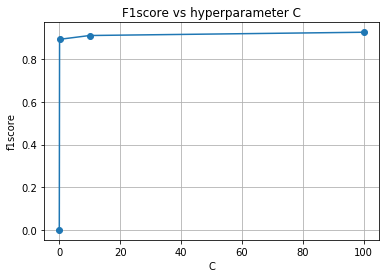

In [75]:
C= 10**-2,10**-1, 10**1,10**2,
plt.plot(C,results['mean_test_score'],marker='o')
plt.xlabel('C')
plt.ylabel('f1score')
plt.title("F1score vs hyperparameter C")
plt.grid()
plt.show()

In [76]:
# Logistic Regression with Optimal value of C(1/lambda)
lr = LogisticRegression(penalty='l1', C=optimal_C,class_weight='balanced', n_jobs=-1)
lr.fit(standardized_data_train,y_train)
pred_tfidf = lr.predict(standardized_data_test)



## 8.2 Confusion Matrix

Confusion Matrix:


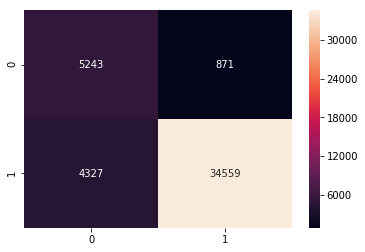

In [77]:
cm_tfidf=confusion_matrix(y_test,pred_tfidf)
print("Confusion Matrix:")
sns.heatmap(cm_tfidf, annot=True, fmt='d')
plt.show()

In [78]:
#finding out  true negative , false positive , false negative and true positve 
tn, fp, fn, tp = cm_tfidf.ravel()
( tp, fp, fn, tp)
print(" true negitves are {} \n false positives are {} \n false negatives are {}\n true positives are {} \n ".format(tn,fp,fn,tp))

 true negitves are 5243 
 false positives are 871 
 false negatives are 4327
 true positives are 34559 
 


## 8.3 Calculating Accuracy,Error on test data,Precision,Recall,Classification Report

In [79]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report


# evaluating accuracy
acc_tfidf = accuracy_score(y_test, pred_tfidf) * 100
print('\nThe Test Accuracy of the Logistic Regression classifier for C = %.3f is %f%%' % (optimal_C, acc_tfidf))

# Error on test data
test_error_tfidf = 100-acc_tfidf
print("\nTest Error  Logistic Regression classifier is  %f%%" % (test_error_tfidf))

# evaluating precision
precision_score = precision_score(y_test, pred_tfidf) 
print('\nThe Test Precision of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, precision_score))

# evaluating recall
recall_score = recall_score(y_test, pred_tfidf)
print('\nThe Test Recall of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, recall_score))

# evaluating Classification report
classification_report = classification_report(y_test, pred_tfidf)
print('\nThe Test classification report of the Logistic regression classifier for C \n\n ',(classification_report))


The Test Accuracy of the Logistic Regression classifier for C = 1.000 is 88.448889%

Test Error  Logistic Regression classifier is  11.551111%

The Test Precision of the Logistic Regression classifier for C = 1.000 is 0.975416

The Test Recall of the Logistic Regression classifier for C = 1.000 is 0.888726

The Test classification report of the Logistic regression classifier for C 

                precision    recall  f1-score   support

           0       0.55      0.86      0.67      6114
           1       0.98      0.89      0.93     38886

   micro avg       0.88      0.88      0.88     45000
   macro avg       0.76      0.87      0.80     45000
weighted avg       0.92      0.88      0.89     45000



## 8.4 Perturbation Test

Pertubation test means adding noise to one of the data point and comparing the difference b/w change in previous weights and New 

weights to find of collinearity.

In [80]:
import scipy as sp
epsilon = sp.stats.distributions.norm.rvs(loc=0,scale=0.0001)
# Vector before the addition of epsilon
W_before_epsilon = lr.coef_

# Number of non zero elements in Standardized_train sparse matrix
no_of_non_zero = standardized_data_train.count_nonzero()

# Importing library to create a sparse matrix of epsilon
from scipy.sparse import csr_matrix

# Creating new sparse matrix with epsilon at same position of non-zero elements of standardized_data_train
x_train_indices = standardized_data_train.indices
x_train_indptr = standardized_data_train.indptr #CSR format index pointer array of the matrix

# Creating a list of same element with repetition
data = [epsilon] * no_of_non_zero
Shape = standardized_data_train.shape

# Creating sparse matrix
sparse_epsilon = csr_matrix((data,x_train_indices,x_train_indptr),shape=Shape,dtype=float)

# Add sparse_epsilon and X-standardized_data_train to get a new sparse matrix with epsilon added to each 
# non-zero element of standardized_data_train
epsilon_train = standardized_data_train + sparse_epsilon

print(standardized_data_train.shape)
print(epsilon_train.shape)

(105000, 38300)
(105000, 38300)


In [81]:
# training Logistic Regression Classifier with epsilon_train
epsilon_lr = LogisticRegression(penalty='l2', C=optimal_C, n_jobs=-1)
epsilon_lr.fit(epsilon_train,y_train)

# Vector after the addition of epsilon
W_after_epsilon = epsilon_lr.coef_

# Change in vectors after adding epsilon
change_vector = W_after_epsilon - W_before_epsilon
print("change_vector",change_vector)


# Sort this change_vector array after making all the elements positive in ascending order to visualize the change
sorted_change_vector = np.sort(np.absolute(change_vector))[:,::-1]

sorted_change_vector[0,0:20]

change_vector [[-0.07292583  0.0018349   0.00097091 ...  0.01937371  0.00278843
   0.01067941]]


array([8.69811668, 8.30776435, 8.28944573, 7.43429387, 7.32158219,
       6.89028413, 6.44075804, 6.27246625, 6.25564712, 6.19544349,
       5.86077886, 5.44274785, 5.44223902, 5.35032615, 5.19127286,
       5.10959871, 5.10217839, 5.08781766, 5.04879578, 4.86708177])

In [82]:
absolute_weights = np.absolute(W_before_epsilon)
sorted_absolute_index = np.argsort(absolute_weights)[:,::-1]
top_index = sorted_absolute_index[0,0:20]

all_features = tf_idf_vect.get_feature_names()
weight_values = lr.coef_

# Top 20 features are    
print("Top 20 features with their weight values :")

for j in top_index:
    print("%12s\t===> \t%f"%(all_features[j],weight_values[0,j]))

Top 20 features with their weight values :
       worst	===> 	-16.314820
       great	===> 	13.289632
      delici	===> 	13.189909
        best	===> 	12.204975
     perfect	===> 	11.592786
     skeptic	===> 	11.365765
     terribl	===> 	-11.155655
        love	===> 	11.075896
        amaz	===> 	10.879753
  disappoint	===> 	-10.871159
        hook	===> 	10.273254
     mediocr	===> 	-9.868479
        beat	===> 	9.699968
     horribl	===> 	-9.594413
       excel	===> 	9.484366
      addict	===> 	9.182978
     finnish	===> 	-9.143331
       uniqu	===> 	8.866093
     compass	===> 	-8.800127
      awesom	===> 	8.763191


## 9. Using L2 Regularization


In [83]:
# Finding the best parameters using Random Seach CV using 2-fold Cross-Validation in Logistic Regression

from sklearn.model_selection import RandomizedSearchCV
param_distributions = {'C': [10**-4,10**-3, 10**-2,10**-1, 1, 10**1,10**2,10**3, 10**4]}
model = RandomizedSearchCV(LogisticRegression(penalty = 'l2',class_weight='balanced'), param_distributions, scoring = 'f1',cv=2, n_iter=4, n_jobs=-1,pre_dispatch=2)
model.fit(standardized_data_train, y_train)
print("The optimal value of C(1/lambda) is : ",model.best_estimator_)
optimal_C = model.best_estimator_.C
print("\n Accuracy of model using L2 Regularization",model.score(standardized_data_test, y_test))

The optimal value of C(1/lambda) is :  LogisticRegression(C=10, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

 Accuracy of model using L2 Regularization 0.9363146336594129


In [84]:
model.best_params_
results = model.cv_results_
results['mean_test_score']


array([0.91919104, 0.89110448, 0.93377054, 0.93620371])

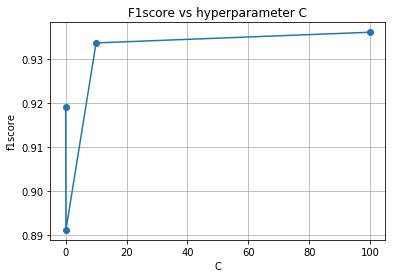

In [85]:
C= 10**-2,10**-1, 10**1,10**2
plt.plot(C,results['mean_test_score'],marker='o')
plt.xlabel('C')
plt.ylabel('f1score')
plt.title("F1score vs hyperparameter C")
plt.grid()
plt.show()

In [86]:
# Logistic Regression with Optimal value of C(1/lambda)
lr = LogisticRegression(penalty='l2', class_weight='balanced',C=optimal_C, n_jobs=-1)
lr.fit(standardized_data_train,y_train)
pred_tfidf = lr.predict(standardized_data_test)



## 9.1 Confusion Matrix

Confusion Matrix:


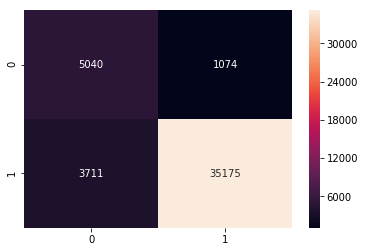

In [87]:
cm_tfidf=confusion_matrix(y_test,pred_tfidf)
print("Confusion Matrix:")
sns.heatmap(cm_tfidf, annot=True, fmt='d')
plt.show()

In [88]:
#finding out  true negative , false positive , false negative and true positve 
tn, fp, fn, tp = cm_tfidf.ravel()
( tp, fp, fn, tp)
print(" true negitves are {} \n false positives are {} \n false negatives are {}\n true positives are {} \n ".format(tn,fp,fn,tp))

 true negitves are 5040 
 false positives are 1074 
 false negatives are 3711
 true positives are 35175 
 


## 9.2 Calculating Accuracy,Error on test data,Precision,Recall,Classification Report

In [89]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report


# evaluating accuracy
acc_tfidf = accuracy_score(y_test, pred_tfidf) * 100
print('\nThe Test Accuracy of the Logistic Regression classifier for C = %.3f is %f%%' % (optimal_C, acc_tfidf))

# Error on test data
test_error_tfidf = 100-acc_tfidf
print("\nTest Error  Logistic Regression classifier is  %f%%" % (test_error_tfidf))

# evaluating precision
precision_score = precision_score(y_test, pred_tfidf) 
print('\nThe Test Precision of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, precision_score))

# evaluating recall
recall_score = recall_score(y_test, pred_tfidf)
print('\nThe Test Recall of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, recall_score))

# evaluating Classification report
classification_report = classification_report(y_test, pred_tfidf)
print('\nThe Test classification report of the Logistic regression classifier for C \n\n ',(classification_report))


The Test Accuracy of the Logistic Regression classifier for C = 10.000 is 89.366667%

Test Error  Logistic Regression classifier is  10.633333%

The Test Precision of the Logistic Regression classifier for C = 10.000 is 0.970372

The Test Recall of the Logistic Regression classifier for C = 10.000 is 0.904567

The Test classification report of the Logistic regression classifier for C 

                precision    recall  f1-score   support

           0       0.58      0.82      0.68      6114
           1       0.97      0.90      0.94     38886

   micro avg       0.89      0.89      0.89     45000
   macro avg       0.77      0.86      0.81     45000
weighted avg       0.92      0.89      0.90     45000



## 9.3 Perturbation Test

Pertubation test means adding noise to one of the data point and comparing the difference b/w change in previous weights and New 

weights to find of collinearity.

In [90]:
import scipy as sp
epsilon = sp.stats.distributions.norm.rvs(loc=0,scale=0.0001)
# Vector before the addition of epsilon
W_before_epsilon = lr.coef_

# Number of non zero elements in Standardized_train sparse matrix
no_of_non_zero = standardized_data_train.count_nonzero()

# Importing library to create a sparse matrix of epsilon
from scipy.sparse import csr_matrix

# Creating new sparse matrix with epsilon at same position of non-zero elements of standardized_data_train
x_train_indices = standardized_data_train.indices
x_train_indptr = standardized_data_train.indptr #CSR format index pointer array of the matrix

# Creating a list of same element with repetition
data = [epsilon] * no_of_non_zero
Shape = standardized_data_train.shape

# Creating sparse matrix
sparse_epsilon = csr_matrix((data,x_train_indices,x_train_indptr),shape=Shape,dtype=float)

# Add sparse_epsilon and X-standardized_data_train to get a new sparse matrix with epsilon added to each 
# non-zero element of standardized_data_train
epsilon_train = standardized_data_train + sparse_epsilon

print(standardized_data_train.shape)
print(epsilon_train.shape)

(105000, 38300)
(105000, 38300)


In [91]:
# training Logistic Regression Classifier with epsilon_train
epsilon_lr = LogisticRegression(penalty='l2', C=optimal_C, n_jobs=-1)
epsilon_lr.fit(epsilon_train,y_train)

# Vector after the addition of epsilon
W_after_epsilon = epsilon_lr.coef_

# Change in vectors after adding epsilon
change_vector = W_after_epsilon - W_before_epsilon
print("change_vector",change_vector)


# Sort this change_vector array after making all the elements positive in ascending order to visualize the change
sorted_change_vector = np.sort(np.absolute(change_vector))[:,::-1]

sorted_change_vector[0,0:20]

change_vector [[ 0.01693745 -0.00744999 -0.0015547  ... -0.04179338 -0.0132322
  -0.08475733]]


array([5.70146967, 4.94566477, 4.8190358 , 4.69320107, 4.59339545,
       4.3911236 , 4.3821337 , 4.3175084 , 4.30677805, 4.21040668,
       4.16150323, 4.01837509, 3.98276153, 3.96020341, 3.77089133,
       3.70838235, 3.69774091, 3.54625368, 3.54237984, 3.53774226])

In [92]:
absolute_weights = np.absolute(W_before_epsilon)
sorted_absolute_index = np.argsort(absolute_weights)[:,::-1]
top_index = sorted_absolute_index[0,0:20]

all_features = tf_idf_vect.get_feature_names()
weight_values = lr.coef_

# Top 20 features are    
print("Top 20 features with their weight values :")

for j in top_index:
    print("%12s\t===> \t%f"%(all_features[j],weight_values[0,j]))

Top 20 features with their weight values :
       worst	===> 	-16.506951
       great	===> 	13.935730
      delici	===> 	13.480723
        best	===> 	12.510217
     perfect	===> 	12.193924
        amaz	===> 	11.647141
     terribl	===> 	-11.615157
        love	===> 	11.590088
  disappoint	===> 	-11.466222
     skeptic	===> 	10.841683
        hook	===> 	10.564185
        beat	===> 	10.195173
     horribl	===> 	-10.162472
      addict	===> 	9.747685
       excel	===> 	9.613320
     finnish	===> 	-9.521802
   sleepless	===> 	-9.335866
      awesom	===> 	9.327967
     mediocr	===> 	-9.293983
     concept	===> 	-9.088311


## 10. WORD2VEC


In [93]:
from gensim.models import Word2Vec
# List of sentence in X_train text
sent_of_train=[]
for sent in x_train:
    sent_of_train.append(sent.split())

# List of sentence in X_est text
sent_of_test=[]
for sent in x_test:
    sent_of_test.append(sent.split())   
    
# Train your own Word2Vec model using your own train text corpus 
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(sent_of_train,min_count=5,size=50, workers=4)

w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))

number of words that occured minimum 5 times  12829


## 11. Avg Word2Vec


In [94]:
# compute average word2vec for each review for X_train .
train_vectors = []; 
for sent in sent_of_train:
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_vectors.append(sent_vec)
    
# compute average word2vec for each review for X_test .
test_vectors = []; 
for sent in sent_of_test:
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_vectors.append(sent_vec)

## 11.1 Standardizing Data

In [95]:
# Data-preprocessing: Standardizing the data
from sklearn import preprocessing
standardized_data_train = preprocessing.normalize(train_vectors)
print(standardized_data_train.shape)
standardized_data_test = preprocessing.normalize(test_vectors)
print(standardized_data_test.shape)


(105000, 50)
(45000, 50)


## 11.2 Applying Logistic Regression Algorithm


## 11.2.1 Gridsearch Cross Validation

## 11.2.1.1 Using L1 Regularization


In [96]:
# Finding the best parameters using Grid Seach CV using 2-fold Cross-Validation in Logistic Regression

from sklearn.model_selection import GridSearchCV
tuned_parameters = [{'C': [10**-4,10**-3, 10**-2,10**-1, 1, 10**1,10**2,10**3, 10**4]}]
model = GridSearchCV(LogisticRegression(penalty = 'l1',class_weight='balanced'), tuned_parameters, scoring = 'f1', cv=2, n_jobs=-1)
model.fit(standardized_data_train, y_train)
print("The optimal value of C(1/lambda) is : ",model.best_estimator_)
optimal_C = model.best_estimator_.C
print("\n Accuracy of model using L1 Regularization",model.score(standardized_data_test, y_test))

The optimal value of C(1/lambda) is :  LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

 Accuracy of model using L1 Regularization 0.8898586577349102


In [97]:
model.best_params_
results = model.cv_results_
results['mean_test_score']


array([0.        , 0.6385385 , 0.87904993, 0.88848874, 0.8891577 ,
       0.88909251, 0.88909247, 0.88909908, 0.88909908])

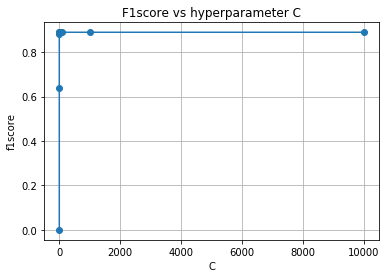

In [98]:
C=10**-4,10**-3, 10**-2,10**-1, 1, 10**1,10**2,10**3, 10**4
plt.plot(C,results['mean_test_score'],marker='o')
plt.xlabel('C')
plt.ylabel('f1score')
plt.title("F1score vs hyperparameter C")
plt.grid()
plt.show()

In [99]:
# Logistic Regression with Optimal value of C(1/lambda)
lr = LogisticRegression(penalty='l1', class_weight='balanced',C=optimal_C, n_jobs=-1)
lr.fit(standardized_data_train,y_train)
pred_avgw2v = lr.predict(standardized_data_test)



## 11.3 Confusion Matrix

Confusion Matrix:


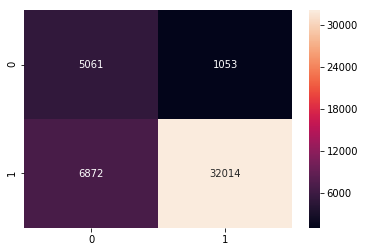

In [100]:
cm_avgw2v=confusion_matrix(y_test,pred_avgw2v)
print("Confusion Matrix:")
sns.heatmap(cm_avgw2v, annot=True, fmt='d')
plt.show()

In [101]:
#finding out  true negative , false positive , false negative and true positve 
tn, fp, fn, tp = cm_avgw2v.ravel()
( tp, fp, fn, tp)
print(" true negitves are {} \n false positives are {} \n false negatives are {}\n true positives are {} \n ".format(tn,fp,fn,tp))

 true negitves are 5061 
 false positives are 1053 
 false negatives are 6872
 true positives are 32014 
 


## 11.4 Calculating Accuracy,Error on test data,Precision,Recall,Classification Report

In [102]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report


# evaluating accuracy
acc_avgw2v = accuracy_score(y_test, pred_avgw2v) * 100
print('\nThe Test Accuracy of the Logistic Regression classifier for C = %.3f is %f%%' % (optimal_C, acc_avgw2v))

# Error on test data
test_error_avgw2v = 100-acc_avgw2v
print("\nTest Error  Logistic Regression classifier is  %f%%" % (test_error_avgw2v))

# evaluating precision
precision_score = precision_score(y_test, pred_avgw2v) 
print('\nThe Test Precision of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, precision_score))

# evaluating recall
recall_score = recall_score(y_test, pred_avgw2v)
print('\nThe Test Recall of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, recall_score))

# evaluating Classification report
classification_report = classification_report(y_test, pred_avgw2v)
print('\nThe Test classification report of the Logistic regression classifier for C \n\n ',(classification_report))


The Test Accuracy of the Logistic Regression classifier for C = 1.000 is 82.388889%

Test Error  Logistic Regression classifier is  17.611111%

The Test Precision of the Logistic Regression classifier for C = 1.000 is 0.968156

The Test Recall of the Logistic Regression classifier for C = 1.000 is 0.823278

The Test classification report of the Logistic regression classifier for C 

                precision    recall  f1-score   support

           0       0.42      0.83      0.56      6114
           1       0.97      0.82      0.89     38886

   micro avg       0.82      0.82      0.82     45000
   macro avg       0.70      0.83      0.73     45000
weighted avg       0.89      0.82      0.85     45000



## 11.5 Checking sparsity with increasing value of lambda(decreasing C)¶

In [103]:
lambd = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
for i in lambd[::-1]:
    lrr = LogisticRegression(penalty = 'l1', C = i)
    lrr.fit(standardized_data_train, y_train)
    print("lambda="+str(1/i)+" ; non-zeros="+str(np.count_nonzero(lrr.coef_)))

lambda=0.0001 ; non-zeros=50
lambda=0.001 ; non-zeros=50
lambda=0.01 ; non-zeros=50
lambda=0.1 ; non-zeros=50
lambda=1.0 ; non-zeros=49
lambda=10.0 ; non-zeros=47
lambda=100.0 ; non-zeros=26
lambda=1000.0 ; non-zeros=2
lambda=10000.0 ; non-zeros=0


In [104]:
lr = LogisticRegression(penalty='l2', C=0.01)
lr.fit(standardized_data_train, y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [105]:
# Applying perturbation and checking if the coefficients differ too much
# Will not add noise to zeros

noise = np.random.normal(0 , 0.1 , 1)
print("Noise= "+str(noise[0]))
standardized_data_train.data = standardized_data_train.data + noise[0]

Noise= -0.015656389247922235


In [106]:
# Fitting the new model on the transformed data

lr2 = LogisticRegression(penalty='l2', C=0.01)
lr2.fit(standardized_data_train, y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [107]:
# Calculating the percentage change between the old and new coefficients
count=0
for i in range(standardized_data_train.shape[1]):
    delta = abs((((lr.coef_[0][i] - lr2.coef_[0][i]) * 100))/ lr.coef_[0][i])
    if delta>40:
        count+=1
        
print("Number of features whose coefficients changed by more than 40% =",count)

Number of features whose coefficients changed by more than 40% = 2


Hence Number of Features whose coefficients changed by more than 40% is less collinear hence we cannot calculate feature importance

As weight vector values before and after pertubation changes significantly, then we can't use |w| as feature importance measure.

## 12. Using L2 Regularization


In [108]:
# Finding the best parameters using Grid Seach CV using 2-fold Cross-Validation in Logistic Regression

from sklearn.model_selection import GridSearchCV
tuned_parameters = [{'C': [10**-4,10**-3,10**-2,10**-1, 1, 10**2,10**3, 10**4]}]
model = GridSearchCV(LogisticRegression(penalty = 'l2',class_weight='balanced'), tuned_parameters, scoring = 'f1', cv=2, n_jobs=-1)
model.fit(standardized_data_train, y_train)

print(model.best_estimator_)
print("Optimal F-score: {:.2f}".format(model.score(standardized_data_test, y_test)))
print(model.score(standardized_data_test, y_test))


LogisticRegression(C=100, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
Optimal F-score: 0.86
0.8618518252886753


In [109]:
model.best_params_
results = model.cv_results_
results['mean_test_score']


array([0.84817229, 0.87082515, 0.88259124, 0.88785519, 0.88904915,
       0.88909247, 0.88909247, 0.88909247])

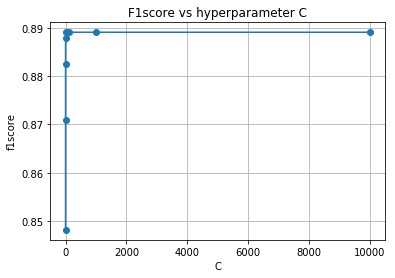

In [110]:
C=10**-3, 10**-2,10**-1, 1, 10**1,10**2,10**3, 10**4
plt.plot(C,results['mean_test_score'],marker='o')
plt.xlabel('C')
plt.ylabel('f1score')
plt.title("F1score vs hyperparameter C")
plt.grid()
plt.show()

In [111]:
# Logistic Regression with Optimal value of C(1/lambda)
lr = LogisticRegression(penalty='l2', class_weight='balanced',C=optimal_C, n_jobs=-1)
lr.fit(standardized_data_train,y_train)
pred_avgw2v = lr.predict(standardized_data_test)



## 12.1 Confusion Matrix

Confusion Matrix:


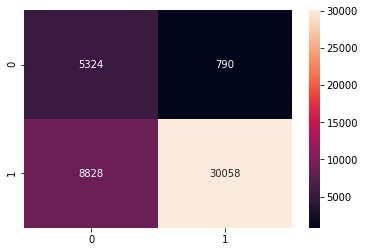

In [112]:
cm_avgw2v=confusion_matrix(y_test,pred_avgw2v)
print("Confusion Matrix:")
sns.heatmap(cm_avgw2v, annot=True, fmt='d')
plt.show()

In [113]:
#finding out  true negative , false positive , false negative and true positve 
tn, fp, fn, tp = cm_avgw2v.ravel()
( tp, fp, fn, tp)
print(" true negitves are {} \n false positives are {} \n false negatives are {}\n true positives are {} \n ".format(tn,fp,fn,tp))

 true negitves are 5324 
 false positives are 790 
 false negatives are 8828
 true positives are 30058 
 


## 12.2 Calculating Accuracy,Error on test data,Precision,Recall,Classification Report

In [114]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report


# evaluating accuracy
acc_avgw2v = accuracy_score(y_test, pred_avgw2v) * 100
print('\nThe Test Accuracy of the Logistic Regression classifier for C = %.3f is %f%%' % (optimal_C, acc_avgw2v))

# Error on test data
test_error_avgw2v = 100-acc_avgw2v
print("\nTest Error  Logistic Regression classifier is  %f%%" % (test_error_avgw2v))

# evaluating precision
precision_score = precision_score(y_test, pred_avgw2v) 
print('\nThe Test Precision of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, precision_score))

# evaluating recall
recall_score = recall_score(y_test, pred_avgw2v)
print('\nThe Test Recall of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, recall_score))

# evaluating Classification report
classification_report = classification_report(y_test, pred_avgw2v)
print('\nThe Test classification report of the Logistic regression classifier for C \n\n ',(classification_report))


The Test Accuracy of the Logistic Regression classifier for C = 1.000 is 78.626667%

Test Error  Logistic Regression classifier is  21.373333%

The Test Precision of the Logistic Regression classifier for C = 1.000 is 0.974391

The Test Recall of the Logistic Regression classifier for C = 1.000 is 0.772977

The Test classification report of the Logistic regression classifier for C 

                precision    recall  f1-score   support

           0       0.38      0.87      0.53      6114
           1       0.97      0.77      0.86     38886

   micro avg       0.79      0.79      0.79     45000
   macro avg       0.68      0.82      0.69     45000
weighted avg       0.89      0.79      0.82     45000



## 12.3 Checking sparsity with increasing value of lambda(decreasing C)¶


In [115]:
lambd = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
for i in lambd[::-1]:
    lrr = LogisticRegression(penalty = 'l1', C = i)
    lrr.fit(standardized_data_train, y_train)
    print("lambda="+str(1/i)+" ; non-zeros="+str(np.count_nonzero(lrr.coef_)))

lambda=0.0001 ; non-zeros=50
lambda=0.001 ; non-zeros=50
lambda=0.01 ; non-zeros=50
lambda=0.1 ; non-zeros=50
lambda=1.0 ; non-zeros=49
lambda=10.0 ; non-zeros=47
lambda=100.0 ; non-zeros=26
lambda=1000.0 ; non-zeros=2
lambda=10000.0 ; non-zeros=0


In [116]:
lr = LogisticRegression(penalty='l2', C=0.01)
lr.fit(standardized_data_train, y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [117]:
# Applying perturbation and checking if the coefficients differ too much
# Will not add noise to zeros

noise = np.random.normal(0 , 0.1 , 1)
print("Noise= "+str(noise[0]))
standardized_data_train.data = standardized_data_train.data + noise[0]

Noise= 0.04927314088689588


In [118]:
# Fitting the new model on the transformed data

lr2 = LogisticRegression(penalty='l2', C=0.01)
lr2.fit(standardized_data_train, y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [119]:
# Calculating the percentage change between the old and new coefficients
count=0
for i in range(standardized_data_train.shape[1]):
    delta = abs((((lr.coef_[0][i] - lr2.coef_[0][i]) * 100))/ lr.coef_[0][i])
    if delta>40:
        count+=1
        
print("Number of features whose coefficients changed by more than 40% =",count)

Number of features whose coefficients changed by more than 40% = 6


Hence Number of Features whose coefficients changed by more than 40% is less collinear hence we cannot calculate feature importance

## 13. Randomized Search Cross Validation


## 13.1 Using L1 Regularization


In [120]:
# Finding the best parameters using Random Seach CV using 2-fold Cross-Validation in Logistic Regression

from sklearn.model_selection import RandomizedSearchCV
param_distributions = {'C': [10**-4,10**-3, 10**-2,10**-1, 1, 10**1,10**2,10**3, 10**4]}
model = RandomizedSearchCV(LogisticRegression(penalty = 'l1',class_weight='balanced'), param_distributions, scoring = 'f1',cv=2, n_iter=4, n_jobs=-1,pre_dispatch=2)
model.fit(standardized_data_train, y_train)
print("The optimal value of C(1/lambda) is : ",model.best_estimator_)
optimal_C = model.best_estimator_.C
print("\n Accuracy of model using L1 Regularization",model.score(standardized_data_test, y_test))

The optimal value of C(1/lambda) is :  LogisticRegression(C=10000, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

 Accuracy of model using L1 Regularization 0.92753394379539


In [121]:
model.best_params_
results = model.cv_results_
results['mean_test_score']


array([0.87895204, 0.88910569, 0.        , 0.88909904])

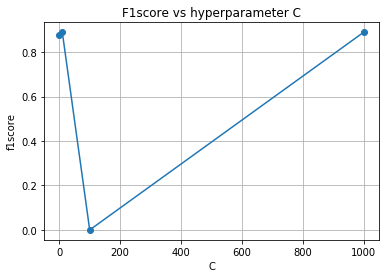

In [122]:
C= 10**-1,10**1,10**2,10**3
plt.plot(C,results['mean_test_score'],marker='o')
plt.xlabel('C')
plt.ylabel('f1score')
plt.title("F1score vs hyperparameter C")
plt.grid()
plt.show()

In [123]:
# Logistic Regression with Optimal value of C(1/lambda)
lr = LogisticRegression(penalty='l1',class_weight='balanced', C=optimal_C, n_jobs=-1)
lr.fit(standardized_data_train,y_train)
pred_avgw2v = lr.predict(standardized_data_test)



## 13.2 Confusion Matrix

Confusion Matrix:


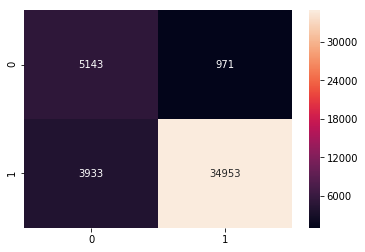

In [124]:
cm_avgw2v=confusion_matrix(y_test,pred_avgw2v)
print("Confusion Matrix:")
sns.heatmap(cm_bow, annot=True, fmt='d')
plt.show()

In [125]:
#finding out  true negative , false positive , false negative and true positve 
tn, fp, fn, tp = cm_avgw2v.ravel()
( tp, fp, fn, tp)
print(" true negitves are {} \n false positives are {} \n false negatives are {}\n true positives are {} \n ".format(tn,fp,fn,tp))

 true negitves are 4241 
 false positives are 1873 
 false negatives are 3633
 true positives are 35253 
 


## 13.3 Calculating Accuracy,Error on test data,Precision,Recall,Classification Report

In [126]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report


# evaluating accuracy
acc_avgw2v = accuracy_score(y_test, pred_avgw2v) * 100
print('\nThe Test Accuracy of the Logistic Regression classifier for C = %.3f is %f%%' % (optimal_C, acc_avgw2v))

# Error on test data
test_error_avgw2v = 100-acc_avgw2v
print("\nTest Error  Logistic Regression classifier is  %f%%" % (test_error_avgw2v))

# evaluating precision
precision_score = precision_score(y_test, pred_avgw2v) 
print('\nThe Test Precision of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, precision_score))

# evaluating recall
recall_score = recall_score(y_test, pred_avgw2v)
print('\nThe Test Recall of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, recall_score))

# evaluating Classification report
classification_report = classification_report(y_test, pred_avgw2v)
print('\nThe Test classification report of the Logistic regression classifier for C \n\n ',(classification_report))


The Test Accuracy of the Logistic Regression classifier for C = 10000.000 is 87.764444%

Test Error  Logistic Regression classifier is  12.235556%

The Test Precision of the Logistic Regression classifier for C = 10000.000 is 0.949550

The Test Recall of the Logistic Regression classifier for C = 10000.000 is 0.906573

The Test classification report of the Logistic regression classifier for C 

                precision    recall  f1-score   support

           0       0.54      0.69      0.61      6114
           1       0.95      0.91      0.93     38886

   micro avg       0.88      0.88      0.88     45000
   macro avg       0.74      0.80      0.77     45000
weighted avg       0.89      0.88      0.88     45000



## 13.4 Perturbation Test

Pertubation test means adding noise to one of the data point and comparing the difference b/w change in previous weights and New 

weights to find of collinearity.

In [127]:
lambd = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
for i in lambd[::-1]:
    lrr = LogisticRegression(penalty = 'l1', C = i)
    lrr.fit(standardized_data_train, y_train)
    print("lambda="+str(1/i)+" ; non-zeros="+str(np.count_nonzero(lrr.coef_)))

lambda=0.0001 ; non-zeros=50
lambda=0.001 ; non-zeros=50
lambda=0.01 ; non-zeros=50
lambda=0.1 ; non-zeros=50
lambda=1.0 ; non-zeros=49
lambda=10.0 ; non-zeros=47
lambda=100.0 ; non-zeros=26
lambda=1000.0 ; non-zeros=1
lambda=10000.0 ; non-zeros=0


In [128]:
lr = LogisticRegression(penalty='l2', C=0.01)
lr.fit(standardized_data_train, y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [129]:
# Applying perturbation and checking if the coefficients differ too much
# Will not add noise to zeros

noise = np.random.normal(0 , 0.1 , 1)
print("Noise= "+str(noise[0]))
standardized_data_train.data = standardized_data_train.data + noise[0]

Noise= -0.03935033248641992


In [130]:
# Fitting the new model on the transformed data

lr2 = LogisticRegression(penalty='l2', C=0.01)
lr2.fit(standardized_data_train.data, y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [131]:
# Calculating the percentage change between the old and new coefficients
count=0
for i in range(standardized_data_train.shape[1]):
    delta = abs((((lr.coef_[0][i] - lr2.coef_[0][i]) * 100))/ lr.coef_[0][i])
    if delta>40:
        count+=1
        
print("Number of features whose coefficients changed by more than 40% =",count)

Number of features whose coefficients changed by more than 40% = 3


Hence Number of Features whose coefficients changed by more than 40% is less collinear hence we cannot calculate feature importance

## 14. Using L2 Regularization


In [132]:
# Finding the best parameters using Random Seach CV using 2-fold Cross-Validation in Logistic Regression

from sklearn.model_selection import RandomizedSearchCV
param_distributions = {'C': [10**-4,10**-3, 10**-2,10**-1, 1, 10**1,10**2,10**3, 10**4]}
model = RandomizedSearchCV(LogisticRegression(penalty = 'l2',class_weight='balanced'), param_distributions, scoring = 'f1',cv=2, n_iter=4, n_jobs=-1,pre_dispatch=2)
model.fit(standardized_data_train, y_train)
print("The optimal value of C(1/lambda) is : ",model.best_estimator_)
optimal_C = model.best_estimator_.C
print("\n Accuracy of model using L2 Regularization",model.score(standardized_data_test, y_test))

The optimal value of C(1/lambda) is :  LogisticRegression(C=10, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

 Accuracy of model using L2 Regularization 0.8810312868617649


In [133]:
model.best_params_
results = model.cv_results_
results['mean_test_score']


array([0.88909247, 0.88911242, 0.88904119, 0.88909247])

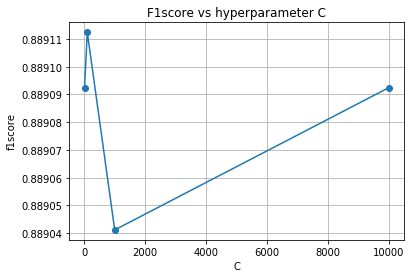

In [134]:
C= 10**1,10**2,10**3, 10**4
plt.plot(C,results['mean_test_score'],marker='o')
plt.xlabel('C')
plt.ylabel('f1score')
plt.title("F1score vs hyperparameter C")
plt.grid()
plt.show()

In [135]:
# Logistic Regression with Optimal value of C(1/lambda)
lr = LogisticRegression(penalty='l2', class_weight='balanced',C=optimal_C, n_jobs=-1)
lr.fit(standardized_data_train,y_train)
pred_avgw2v = lr.predict(standardized_data_test)

## 14..1 Confusion Matrix


Confusion Matrix:


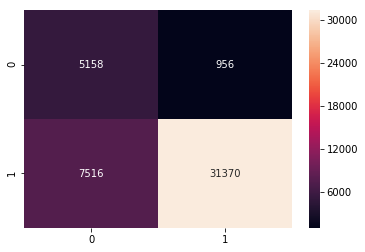

In [136]:
cm_avgw2v=confusion_matrix(y_test,pred_avgw2v)
print("Confusion Matrix:")
sns.heatmap(cm_avgw2v, annot=True, fmt='d')
plt.show()

In [137]:
#finding out  true negative , false positive , false negative and true positve 
tn, fp, fn, tp = cm_avgw2v.ravel()
( tp, fp, fn, tp)
print(" true negitves are {} \n false positives are {} \n false negatives are {}\n true positives are {} \n ".format(tn,fp,fn,tp))

 true negitves are 5158 
 false positives are 956 
 false negatives are 7516
 true positives are 31370 
 


## 14.2 Calculating Accuracy,Error on test data,Precision,Recall,Classification Report

In [138]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report


# evaluating accuracy
acc_avgw2v = accuracy_score(y_test, pred_avgw2v) * 100
print('\nThe Test Accuracy of the Logistic Regression classifier for C = %.3f is %f%%' % (optimal_C, acc_avgw2v))

# Error on test data
test_error_avgw2v = 100-acc_avgw2v
print("\nTest Error  Logistic Regression classifier is  %f%%" % (test_error_avgw2v))

# evaluating precision
precision_score = precision_score(y_test, pred_avgw2v) 
print('\nThe Test Precision of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, precision_score))

# evaluating recall
recall_score = recall_score(y_test, pred_avgw2v)
print('\nThe Test Recall of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, recall_score))

# evaluating Classification report
classification_report = classification_report(y_test, pred_avgw2v)
print('\nThe Test classification report of the Logistic regression classifier for C \n\n ',(classification_report))


The Test Accuracy of the Logistic Regression classifier for C = 10.000 is 81.173333%

Test Error  Logistic Regression classifier is  18.826667%

The Test Precision of the Logistic Regression classifier for C = 10.000 is 0.970426

The Test Recall of the Logistic Regression classifier for C = 10.000 is 0.806717

The Test classification report of the Logistic regression classifier for C 

                precision    recall  f1-score   support

           0       0.41      0.84      0.55      6114
           1       0.97      0.81      0.88     38886

   micro avg       0.81      0.81      0.81     45000
   macro avg       0.69      0.83      0.72     45000
weighted avg       0.89      0.81      0.84     45000



## 14.3 Perturbation Test

Pertubation test means adding noise to one of the data point and comparing the difference b/w change in previous weights and New 

weights to find of collinearity.

In [139]:
lambd = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
for i in lambd[::-1]:
    lrr = LogisticRegression(penalty = 'l1', C = i)
    lrr.fit(standardized_data_train, y_train)
    print("lambda="+str(1/i)+" ; non-zeros="+str(np.count_nonzero(lrr.coef_)))

lambda=0.0001 ; non-zeros=50
lambda=0.001 ; non-zeros=50
lambda=0.01 ; non-zeros=50
lambda=0.1 ; non-zeros=50
lambda=1.0 ; non-zeros=49
lambda=10.0 ; non-zeros=47
lambda=100.0 ; non-zeros=26
lambda=1000.0 ; non-zeros=2
lambda=10000.0 ; non-zeros=0


In [140]:
lr = LogisticRegression(penalty='l2', C=0.01)
lr.fit(standardized_data_train, y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [141]:
# Applying perturbation and checking if the coefficients differ too much
# Will not add noise to zeros

noise = np.random.normal(0 , 0.1 , 1)
print("Noise= "+str(noise[0]))
standardized_data_train.data = standardized_data_train.data + noise[0]

Noise= 0.07270451602395143


In [142]:
# Fitting the new model on the transformed data

lr2 = LogisticRegression(penalty='l2', C=0.01)
lr2.fit(standardized_data_train, y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [143]:
# Calculating the percentage change between the old and new coefficients
count=0
for i in range(standardized_data_train.shape[1]):
    delta = abs((((lr.coef_[0][i] - lr2.coef_[0][i]) * 100))/ lr.coef_[0][i])
    if delta>40:
        count+=1
        
print("Number of features whose coefficients changed by more than 40% =",count)

Number of features whose coefficients changed by more than 40% = 7


Hence Number of Features whose coefficients changed by more than 40% is less collinear hence we cannot calculate feature importance

## 15.TFIDF-Word2Vec


In [144]:
#tf-idf weighted w2v

from sklearn.feature_extraction.text import TfidfVectorizer

tfidfw2v_vect = TfidfVectorizer()
final_counts_tfidfw2v_train= tfidfw2v_vect.fit_transform(x_train) 
print(type(final_counts_tfidfw2v_train))
print(final_counts_tfidfw2v_train.shape)

final_counts_tfidfw2v_test= tfidfw2v_vect.transform(x_test) 
print(type(final_counts_tfidfw2v_test))
print(final_counts_tfidfw2v_test.shape)

<class 'scipy.sparse.csr.csr_matrix'>
(105000, 38300)
<class 'scipy.sparse.csr.csr_matrix'>
(45000, 38300)


In [145]:
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidfw2v_vect.get_feature_names(), list(tfidfw2v_vect.idf_)))


# TF-IDF weighted Word2Vec
tfidf_feat = tfidfw2v_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in sent_of_train: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

#Test case

tfidf_sent_vectors1 = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in sent_of_test: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors1.append(sent_vec)
    row += 1
print(len(tfidf_sent_vectors))
print(len(tfidf_sent_vectors1))




105000
45000


## 15.1 Standardizing Data

In [146]:
# Data-preprocessing: Standardizing the data
from sklearn import preprocessing
standardized_data_train = preprocessing.normalize(tfidf_sent_vectors)
print(standardized_data_train.shape)
standardized_data_test = preprocessing.normalize(tfidf_sent_vectors1)
print(standardized_data_test.shape)


(105000, 50)
(45000, 50)


## 15.2 Applying Logistic Regression Algorithm


## 15.2.1 Gridsearch Cross Validation

## 15.2.1.1 Using L1 Regularization


In [147]:
# Finding the best parameters using Grid Seach CV using 2-fold Cross-Validation in Logistic Regression

from sklearn.model_selection import GridSearchCV
tuned_parameters = [{'C': [10**-4,10**-3, 10**-2,10**-1, 1, 10**1,10**2,10**3, 10**4]}]
model = GridSearchCV(LogisticRegression(penalty = 'l1',class_weight='balanced'), tuned_parameters, scoring = 'f1', cv=2, n_jobs=-1)
model.fit(standardized_data_train, y_train)
print("The optimal value of C(1/lambda) is : ",model.best_estimator_)
optimal_C = model.best_estimator_.C
print("\n Accuracy of model using L1 Regularization",model.score(standardized_data_test, y_test))

The optimal value of C(1/lambda) is :  LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

 Accuracy of model using L1 Regularization 0.8730737923484997


In [148]:
model.best_params_
results = model.cv_results_
results['mean_test_score']


array([0.        , 0.57046139, 0.86394916, 0.87178012, 0.87173324,
       0.87170356, 0.87167311, 0.87165945, 0.87167311])

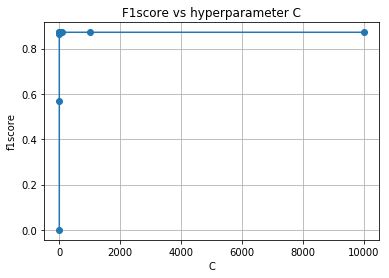

In [149]:
C=10**-4,10**-3, 10**-2,10**-1, 1, 10**1,10**2,10**3, 10**4
plt.plot(C,results['mean_test_score'],marker='o')
plt.xlabel('C')
plt.ylabel('f1score')
plt.title("F1score vs hyperparameter C")
plt.grid()
plt.show()

In [150]:
# Logistic Regression with Optimal value of C(1/lambda)
lr = LogisticRegression(penalty='l2',class_weight='balanced', C=optimal_C, n_jobs=-1)
lr.fit(standardized_data_train,y_train)
pred_tfidfw2v = lr.predict(standardized_data_test)

## 15.3 Confusion Matrix

Confusion Matrix:


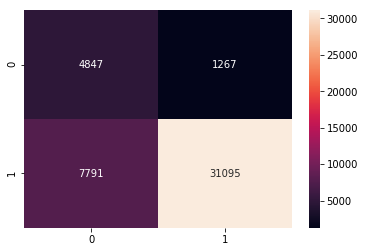

In [151]:
cm_tfidfw2v=confusion_matrix(y_test,pred_tfidfw2v)
print("Confusion Matrix:")
sns.heatmap(cm_tfidfw2v, annot=True, fmt='d')
plt.show()

In [152]:
#finding out  true negative , false positive , false negative and true positve 
tn, fp, fn, tp = cm_tfidfw2v.ravel()
( tp, fp, fn, tp)
print(" true negitves are {} \n false positives are {} \n false negatives are {}\n true positives are {} \n ".format(tn,fp,fn,tp))

 true negitves are 4847 
 false positives are 1267 
 false negatives are 7791
 true positives are 31095 
 


## 15.4 Calculating Accuracy,Error on test data,Precision,Recall,Classification Report

In [153]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report


# evaluating accuracy
acc_tfidfw2v = accuracy_score(y_test, pred_tfidfw2v) * 100
print('\nThe Test Accuracy of the Logistic Regression classifier for C = %.3f is %f%%' % (optimal_C, acc_tfidfw2v))

# Error on test data
test_error_tfidfw2v = 100-acc_tfidfw2v
print("\nTest Error  Logistic Regression classifier is  %f%%" % (test_error_tfidfw2v))

# evaluating precision
precision_score = precision_score(y_test, pred_tfidfw2v) 
print('\nThe Test Precision of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, precision_score))

# evaluating recall
recall_score = recall_score(y_test, pred_tfidfw2v)
print('\nThe Test Recall of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, recall_score))

# evaluating Classification report
classification_report = classification_report(y_test, pred_tfidfw2v)
print('\nThe Test classification report of the Logistic regression classifier for C \n\n ',(classification_report))


The Test Accuracy of the Logistic Regression classifier for C = 0.100 is 79.871111%

Test Error  Logistic Regression classifier is  20.128889%

The Test Precision of the Logistic Regression classifier for C = 0.100 is 0.960849

The Test Recall of the Logistic Regression classifier for C = 0.100 is 0.799645

The Test classification report of the Logistic regression classifier for C 

                precision    recall  f1-score   support

           0       0.38      0.79      0.52      6114
           1       0.96      0.80      0.87     38886

   micro avg       0.80      0.80      0.80     45000
   macro avg       0.67      0.80      0.69     45000
weighted avg       0.88      0.80      0.82     45000



## 15.5 Perturbation Test

Pertubation test means adding noise to one of the data point and comparing the difference b/w change in previous weights and New 

weights to find of collinearity.

In [154]:
lambd = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
for i in lambd[::-1]:
    lrr = LogisticRegression(penalty = 'l1', C = i)
    lrr.fit(standardized_data_train, y_train)
    print("lambda="+str(1/i)+" ; non-zeros="+str(np.count_nonzero(lrr.coef_)))

lambda=0.0001 ; non-zeros=50
lambda=0.001 ; non-zeros=50
lambda=0.01 ; non-zeros=50
lambda=0.1 ; non-zeros=50
lambda=1.0 ; non-zeros=50
lambda=10.0 ; non-zeros=46
lambda=100.0 ; non-zeros=27
lambda=1000.0 ; non-zeros=1
lambda=10000.0 ; non-zeros=0


In [155]:
lr = LogisticRegression(penalty='l2', C=0.01)
lr.fit(standardized_data_train, y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [156]:
# Applying perturbation and checking if the coefficients differ too much
# Will not add noise to zeros

noise = np.random.normal(0 , 0.1 , 1)
print("Noise= "+str(noise[0]))
standardized_data_train.data = standardized_data_train.data + noise[0]

Noise= -0.1665073684144514


In [157]:
# Fitting the new model on the transformed data

lr2 = LogisticRegression(penalty='l2', C=0.01)
lr2.fit(standardized_data_train, y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [158]:
# Calculating the percentage change between the old and new coefficients
count=0
for i in range(standardized_data_train.shape[1]):
    delta = abs((((lr.coef_[0][i] - lr2.coef_[0][i]) * 100))/ lr.coef_[0][i])
    if delta>40:
        count+=1
        
print("Number of features whose coefficients changed by more than 40% =",count)

Number of features whose coefficients changed by more than 40% = 6


Hence Number of Features whose coefficients changed by more than 40% is less tese are less collineare hence we cannot calculate feature importance

## 16 Using L2 Regularization


In [159]:
# Finding the best parameters using Grid Seach CV using 2-fold Cross-Validation in Logistic Regression

from sklearn.model_selection import GridSearchCV
tuned_parameters = [{'C': [10**-5,10**-4,10**-3,10**-2,10**-1, 1, 10**2,10**3, 10**4]}]
model = GridSearchCV(LogisticRegression(penalty = 'l2',class_weight='balanced'), tuned_parameters, scoring = 'f1', cv=2, n_jobs=-1)
model.fit(standardized_data_train, y_train)

print(model.best_estimator_)
print("Optimal F-score: {:.2f}".format(model.score(standardized_data_test, y_test)))
print(model.score(standardized_data_test, y_test))


LogisticRegression(C=1e-05, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
Optimal F-score: 0.76
0.7578441018913306


In [160]:
model.best_params_
results = model.cv_results_
results['mean_test_score']


array([0.90855596, 0.87482889, 0.86472308, 0.86956968, 0.8713644 ,
       0.87166628, 0.87167994, 0.87167307, 0.87167307])

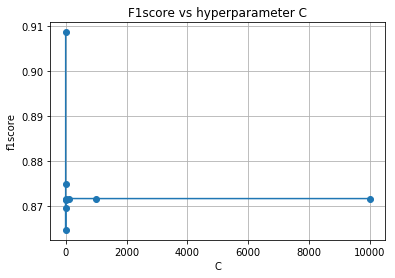

In [161]:
C=10**-4,10**-3, 10**-2,10**-1, 1, 10**1,10**2,10**3, 10**4
plt.plot(C,results['mean_test_score'],marker='o')
plt.xlabel('C')
plt.ylabel('f1score')
plt.title("F1score vs hyperparameter C")
plt.grid()
plt.show()

In [162]:
# Logistic Regression with Optimal value of C(1/lambda)
lr = LogisticRegression(penalty='l2',class_weight='balanced', C=optimal_C, n_jobs=-1)
lr.fit(standardized_data_train,y_train)
pred_tfidfw2v = lr.predict(standardized_data_test)

## 16.1 Confusion Matrix

Confusion Matrix:


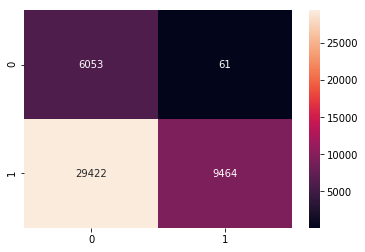

In [163]:
cm_tfidfw2v=confusion_matrix(y_test,pred_tfidfw2v)
print("Confusion Matrix:")
sns.heatmap(cm_tfidfw2v, annot=True, fmt='d')
plt.show()

In [164]:
#finding out  true negative , false positive , false negative and true positve 
tn, fp, fn, tp = cm_tfidfw2v.ravel()
( tp, fp, fn, tp)
print(" true negitves are {} \n false positives are {} \n false negatives are {}\n true positives are {} \n ".format(tn,fp,fn,tp))

 true negitves are 6053 
 false positives are 61 
 false negatives are 29422
 true positives are 9464 
 


## 16.2 Calculating Accuracy,Error on test data,Precision,Recall,Classification Report

In [165]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report


# evaluating accuracy
acc_tfidfw2v = accuracy_score(y_test, pred_tfidfw2v) * 100
print('\nThe Test Accuracy of the Logistic Regression classifier for C = %.3f is %f%%' % (optimal_C, acc_tfidfw2v))

# Error on test data
test_error_tfidfw2v = 100-acc_tfidfw2v
print("\nTest Error  Logistic Regression classifier is  %f%%" % (test_error_tfidfw2v))

# evaluating precision
precision_score = precision_score(y_test, pred_tfidfw2v) 
print('\nThe Test Precision of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, precision_score))

# evaluating recall
recall_score = recall_score(y_test, pred_tfidfw2v)
print('\nThe Test Recall of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, recall_score))

# evaluating Classification report
classification_report = classification_report(y_test, pred_tfidfw2v)
print('\nThe Test classification report of the Logistic regression classifier for C \n\n ',(classification_report))


The Test Accuracy of the Logistic Regression classifier for C = 0.100 is 34.482222%

Test Error  Logistic Regression classifier is  65.517778%

The Test Precision of the Logistic Regression classifier for C = 0.100 is 0.993596

The Test Recall of the Logistic Regression classifier for C = 0.100 is 0.243378

The Test classification report of the Logistic regression classifier for C 

                precision    recall  f1-score   support

           0       0.17      0.99      0.29      6114
           1       0.99      0.24      0.39     38886

   micro avg       0.34      0.34      0.34     45000
   macro avg       0.58      0.62      0.34     45000
weighted avg       0.88      0.34      0.38     45000



## 16.3 Perturbation Test

Pertubation test means adding noise to one of the data point and comparing the difference b/w change in previous weights and New 

weights to find of collinearity.

In [166]:
lambd = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
for i in lambd[::-1]:
    lrr = LogisticRegression(penalty = 'l1', C = i)
    lrr.fit(standardized_data_train, y_train)
    print("lambda="+str(1/i)+" ; non-zeros="+str(np.count_nonzero(lrr.coef_)))

lambda=0.0001 ; non-zeros=50
lambda=0.001 ; non-zeros=50
lambda=0.01 ; non-zeros=50
lambda=0.1 ; non-zeros=50
lambda=1.0 ; non-zeros=50
lambda=10.0 ; non-zeros=46
lambda=100.0 ; non-zeros=29
lambda=1000.0 ; non-zeros=2
lambda=10000.0 ; non-zeros=0


In [167]:
lr = LogisticRegression(penalty='l2', C=0.01)
lr.fit(standardized_data_train, y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [168]:
# Applying perturbation and checking if the coefficients differ too much
# Will not add noise to zeros

noise = np.random.normal(0 , 0.1 , 1)
print("Noise= "+str(noise[0]))
standardized_data_train.data = standardized_data_train.data + noise[0]

Noise= -0.06077136778394751


In [169]:
# Fitting the new model on the transformed data

lr2 = LogisticRegression(penalty='l2', C=0.01)
lr2.fit(standardized_data_train, y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [170]:
# Calculating the percentage change between the old and new coefficients
count=0
for i in range(standardized_data_train.shape[1]):
    delta = abs((((lr.coef_[0][i] - lr2.coef_[0][i]) * 100))/ lr.coef_[0][i])
    if delta>40:
        count+=1
        
print("Number of features whose coefficients changed by more than 40% =",count)

Number of features whose coefficients changed by more than 40% = 4


Hence Number of Features whose coefficients changed by more than 40% is less collinear hence we cannot calculate feature importance

## 17. Randomized Search Cross Validation


## 17.1 Using L1 Regularization


In [171]:
# Finding the best parameters using Random Seach CV using 2-fold Cross-Validation in Logistic Regression

from sklearn.model_selection import RandomizedSearchCV
param_distributions = {'C': [10**-4,10**-3, 10**-2,10**-1, 1, 10**1,10**2,10**3, 10**4]}
model = RandomizedSearchCV(LogisticRegression(penalty = 'l1',class_weight='balanced'), param_distributions, scoring = 'f1',cv=2, n_iter=4, n_jobs=-1,pre_dispatch=2)
model.fit(standardized_data_train, y_train)
print("The optimal value of C(1/lambda) is : ",model.best_estimator_)
optimal_C = model.best_estimator_.C
print("\n Accuracy of model using L1 Regularization",model.score(standardized_data_test, y_test))

The optimal value of C(1/lambda) is :  LogisticRegression(C=0.001, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

 Accuracy of model using L1 Regularization 0.5788149000431468


In [172]:
model.best_params_
results = model.cv_results_
results['mean_test_score']


array([0.87185215, 0.90359562, 0.        , 0.87166408])

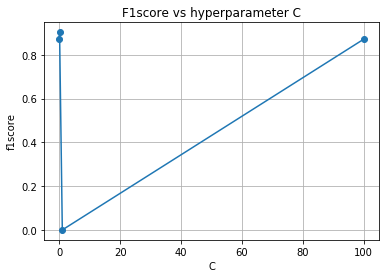

In [173]:
C= 10**-2,10**-1, 1, 10**2
plt.plot(C,results['mean_test_score'],marker='o')
plt.xlabel('C')
plt.ylabel('f1score')
plt.title("F1score vs hyperparameter C")
plt.grid()
plt.show()

In [174]:
# Logistic Regression with Optimal value of C(1/lambda)
lr = LogisticRegression(penalty='l2', class_weight='balanced',C=optimal_C, n_jobs=-1)
lr.fit(standardized_data_train,y_train)
pred_tfidfw2v = lr.predict(standardized_data_test)

## 17.2 Confusion Matrix

Confusion Matrix:


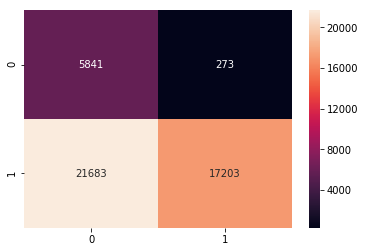

In [175]:
cm_tfidfw2v=confusion_matrix(y_test,pred_tfidfw2v)
print("Confusion Matrix:")
sns.heatmap(cm_tfidfw2v, annot=True, fmt='d')
plt.show()

In [176]:
#finding out  true negative , false positive , false negative and true positve 
tn, fp, fn, tp = cm_tfidfw2v.ravel()
( tp, fp, fn, tp)
print(" true negitves are {} \n false positives are {} \n false negatives are {}\n true positives are {} \n ".format(tn,fp,fn,tp))

 true negitves are 5841 
 false positives are 273 
 false negatives are 21683
 true positives are 17203 
 


## 17.3 Calculating Accuracy,Error on test data,Precision,Recall,Classification Report

In [177]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report


# evaluating accuracy
acc_tfidfw2v = accuracy_score(y_test, pred_tfidfw2v) * 100
print('\nThe Test Accuracy of the Logistic Regression classifier for C = %.3f is %f%%' % (optimal_C, acc_tfidfw2v))

# Error on test data
test_error_tfidfw2v = 100-acc_tfidfw2v
print("\nTest Error  Logistic Regression classifier is  %f%%" % (test_error_tfidfw2v))

# evaluating precision
precision_score = precision_score(y_test, pred_tfidfw2v) 
print('\nThe Test Precision of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, precision_score))

# evaluating recall
recall_score = recall_score(y_test, pred_tfidfw2v)
print('\nThe Test Recall of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, recall_score))

# evaluating Classification report
classification_report = classification_report(y_test, pred_tfidfw2v)
print('\nThe Test classification report of the Logistic regression classifier for C \n\n ',(classification_report))


The Test Accuracy of the Logistic Regression classifier for C = 0.001 is 51.208889%

Test Error  Logistic Regression classifier is  48.791111%

The Test Precision of the Logistic Regression classifier for C = 0.001 is 0.984379

The Test Recall of the Logistic Regression classifier for C = 0.001 is 0.442396

The Test classification report of the Logistic regression classifier for C 

                precision    recall  f1-score   support

           0       0.21      0.96      0.35      6114
           1       0.98      0.44      0.61     38886

   micro avg       0.51      0.51      0.51     45000
   macro avg       0.60      0.70      0.48     45000
weighted avg       0.88      0.51      0.57     45000



## 17.4 Perturbation Test

Pertubation test means adding noise to one of the data point and comparing the difference b/w change in previous weights and New 

weights to find of collinearity.

In [178]:
lambd = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
for i in lambd[::-1]:
    lrr = LogisticRegression(penalty = 'l1', C = i)
    lrr.fit(standardized_data_train, y_train)
    print("lambda="+str(1/i)+" ; non-zeros="+str(np.count_nonzero(lrr.coef_)))

lambda=0.0001 ; non-zeros=50
lambda=0.001 ; non-zeros=50
lambda=0.01 ; non-zeros=50
lambda=0.1 ; non-zeros=50
lambda=1.0 ; non-zeros=50
lambda=10.0 ; non-zeros=46
lambda=100.0 ; non-zeros=29
lambda=1000.0 ; non-zeros=2
lambda=10000.0 ; non-zeros=0


In [179]:
lr = LogisticRegression(penalty='l2', C=0.01)
lr.fit(standardized_data_train, y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [180]:
# Applying perturbation and checking if the coefficients differ too much
# Will not add noise to zeros

noise = np.random.normal(0 , 0.1 , 1)
print("Noise= "+str(noise[0]))
standardized_data_train.data = standardized_data_train.data + noise[0]

Noise= -0.23088376788552464


In [181]:
# Fitting the new model on the transformed data

lr2 = LogisticRegression(penalty='l2', C=0.01)
lr2.fit(standardized_data_train, y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [182]:
# Calculating the percentage change between the old and new coefficients
count=0
for i in range(standardized_data_train.shape[1]):
    delta = abs((((lr.coef_[0][i] - lr2.coef_[0][i]) * 100))/ lr.coef_[0][i])
    if delta>40:
        count+=1
        
print("Number of features whose coefficients changed by more than 40% =",count)

Number of features whose coefficients changed by more than 40% = 9


Hence Number of Features whose coefficients changed by more than 40% is less collinear hence we cannot calculate feature importance

## 18. Using L2 Regularization


In [183]:
# Finding the best parameters using Random Seach CV using 2-fold Cross-Validation in Logistic Regression

from sklearn.model_selection import RandomizedSearchCV
param_distributions = {'C': [10**-4,10**-3, 10**-2,10**-1, 1, 10**1,10**2,10**3, 10**4]}
model = RandomizedSearchCV(LogisticRegression(penalty = 'l2',class_weight='balanced'), param_distributions, scoring = 'f1',cv=2, n_iter=4, n_jobs=-1,pre_dispatch=2)
model.fit(standardized_data_train, y_train)
print("The optimal value of C(1/lambda) is : ",model.best_estimator_)
optimal_C = model.best_estimator_.C
print("\n Accuracy of model using L2 Regularization",model.score(standardized_data_test, y_test))

The optimal value of C(1/lambda) is :  LogisticRegression(C=1000, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

 Accuracy of model using L2 Regularization 0.00030854674483184197


In [184]:
model.best_params_
results = model.cv_results_
results['mean_test_score']


array([0.86160476, 0.87163863, 0.8716799 , 0.87088299])

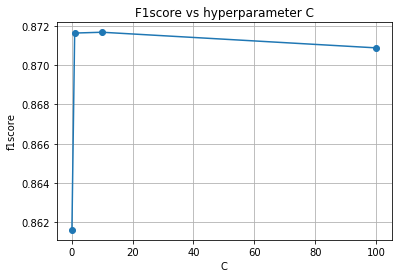

In [185]:
C=10**-1, 1, 10**1,10**2
plt.plot(C,results['mean_test_score'],marker='o')
plt.xlabel('C')
plt.ylabel('f1score')
plt.title("F1score vs hyperparameter C")
plt.grid()
plt.show()

In [186]:
# Logistic Regression with Optimal value of C(1/lambda)
lr = LogisticRegression(penalty='l2',class_weight='balanced', C=optimal_C, n_jobs=-1)
lr.fit(standardized_data_train,y_train)
pred_tfidfw2v = lr.predict(standardized_data_test)

## 18.1 Confusion Matrix

Confusion Matrix:


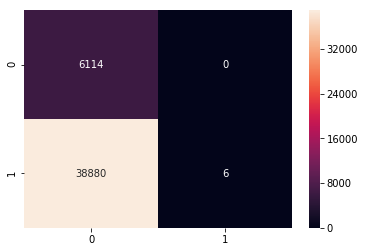

In [187]:
cm_tfidfw2v=confusion_matrix(y_test,pred_tfidfw2v)
print("Confusion Matrix:")
sns.heatmap(cm_tfidfw2v, annot=True, fmt='d')
plt.show()

In [188]:
#finding out  true negative , false positive , false negative and true positve 
tn, fp, fn, tp = cm_tfidfw2v.ravel()
( tp, fp, fn, tp)
print(" true negitves are {} \n false positives are {} \n false negatives are {}\n true positives are {} \n ".format(tn,fp,fn,tp))

 true negitves are 6114 
 false positives are 0 
 false negatives are 38880
 true positives are 6 
 


## 18.2 Calculating Accuracy,Error on test data,Precision,Recall,Classification Report

In [189]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report


# evaluating accuracy
acc_tfidfw2v = accuracy_score(y_test, pred_tfidfw2v) * 100
print('\nThe Test Accuracy of the Logistic Regression classifier for C = %.3f is %f%%' % (optimal_C, acc_tfidfw2v))

# Error on test data
test_error_tfidfw2v = 100-acc_tfidfw2v
print("\nTest Error  Logistic Regression classifier is  %f%%" % (test_error_tfidfw2v))

# evaluating precision
precision_score = precision_score(y_test, pred_tfidfw2v) 
print('\nThe Test Precision of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, precision_score))

# evaluating recall
recall_score = recall_score(y_test, pred_tfidfw2v)
print('\nThe Test Recall of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, recall_score))

# evaluating Classification report
classification_report = classification_report(y_test, pred_tfidfw2v)
print('\nThe Test classification report of the Logistic regression classifier for C \n\n ',(classification_report))


The Test Accuracy of the Logistic Regression classifier for C = 1000.000 is 13.600000%

Test Error  Logistic Regression classifier is  86.400000%

The Test Precision of the Logistic Regression classifier for C = 1000.000 is 1.000000

The Test Recall of the Logistic Regression classifier for C = 1000.000 is 0.000154

The Test classification report of the Logistic regression classifier for C 

                precision    recall  f1-score   support

           0       0.14      1.00      0.24      6114
           1       1.00      0.00      0.00     38886

   micro avg       0.14      0.14      0.14     45000
   macro avg       0.57      0.50      0.12     45000
weighted avg       0.88      0.14      0.03     45000



## 18.3 Perturbation Test

Pertubation test means adding noise to one of the data point and comparing the difference b/w change in previous weights and New 

weights to find of collinearity.

In [190]:
lambd = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
for i in lambd[::-1]:
    lrr = LogisticRegression(penalty = 'l1', C = i)
    lrr.fit(standardized_data_train, y_train)
    print("lambda="+str(1/i)+" ; non-zeros="+str(np.count_nonzero(lrr.coef_)))

lambda=0.0001 ; non-zeros=50
lambda=0.001 ; non-zeros=50
lambda=0.01 ; non-zeros=50
lambda=0.1 ; non-zeros=50
lambda=1.0 ; non-zeros=50
lambda=10.0 ; non-zeros=48
lambda=100.0 ; non-zeros=31
lambda=1000.0 ; non-zeros=4
lambda=10000.0 ; non-zeros=0


In [191]:
lr = LogisticRegression(penalty='l2', C=0.01)
lr.fit(standardized_data_train, y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [192]:
# Applying perturbation and checking if the coefficients differ too much
# Will not add noise to zeros

noise = np.random.normal(0 , 0.1 , 1)
print("Noise= "+str(noise[0]))
standardized_data_train.data = standardized_data_train.data + noise[0]

Noise= -0.061877811121505734


In [193]:
# Fitting the new model on the transformed data

lr2 = LogisticRegression(penalty='l2', C=0.01)
lr2.fit(standardized_data_train, y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [194]:
# Calculating the percentage change between the old and new coefficients
count=0
for i in range(standardized_data_train.shape[1]):
    delta = abs((((lr.coef_[0][i] - lr2.coef_[0][i]) * 100))/ lr.coef_[0][i])
    if delta>40:
        count+=1
        
print("Number of features whose coefficients changed by more than 40% =",count)

Number of features whose coefficients changed by more than 40% = 2


Hence Number of Features whose coefficients changed by more than 40% is less collinear hence we cannot calculate feature importance

## 19.Conclusion

## Model performance table

-----------------------------------------------------------------------------------------------------------------------
|                                            GRID SEARCH                                                              |
-----------------------------------------------------------------------------------------------------------------------------
|           Model                    | Hyper parameter(c) with GRID search  | Regularizer  | Train Error  | Accuracy  |
|:----------------------------------:|:------------------------------------:|:------------:|:------------:|:---------:|
| Logistic Regression with Bow       | 100                                  |   L2         |11.724444     |88.275556  |
| Logistic Regression with Tfidf     | 10                                   |   L2         |10.63333      |89.366667  |
| Logistic Regression with Avgw2v    | 1                                    |   L2         |21.37333      |78.626667  |
| Logistic Regression with Tfidfw2v  | 0.100                                |   L2         |65.517778     |34.482222  |
-----------------------------------------------------------------------------------------------------------------------------
|                                            RANDOM SEARCH                                                            |
-----------------------------------------------------------------------------------------------------------------------------
|           Model                    | Hyper parameter(c) with Random search| Regularizer  | Train Error  | Accuracy  |
|:----------------------------------:|:------------------------------------:|:------------:|:------------:|:---------:|
| Logistic Regression with Bow       | 10                                   |   L2         |10.897778     |89.102222  |
| Logistic Regression with Tfidf     | 10                                   |   L2         |10.633333     |89.366667  |
| Logistic Regression with Avgw2v    | 10                                   |   L2         |18.826667     |81.173333  |
| Logistic Regression with Tfidfw2v  | 1000                                 |   L2         |86.400000     |13.600000  |
-----------------------------------------------------------------------------------------------------------------------------

 Logistic regression is used to describe data and to explain the relationship between one dependent binary variable and one or more nominal, ordinal, interval or ratio-level independent variables.

Logistic regression is used to obtain odds ratio in the presence of more than one explanatory variable.

Logistic regression does not assume a linear relationship between the dependent variable and the independent variables, but it does assume linear relationship between the logit of the explanatory variables and the response.

Independent variables can be even the power terms or some other nonlinear transformations of the original independent variables

The dependent variable does NOT need to be normally distributed, but it typically assumes a distribution from an exponential family (e.g. binomial, Poisson, multinomial, normal,...); binary logistic regression assume binomial distribution of the response

The goal of logistic regression is to correctly predict the category of outcome for individual cases using the most parsimonious model. To accomplish this goal, a model is created that includes all predictor variables that are useful in predicting the response variable.

Assumptions of Logistic Regression

1)logistic regression does not require a linear relationship between the dependent and independent variables. 

2)Second, the error terms (residuals) do not need to be normally distributed.  

3)Third, homoscedasticity is not required.  

4)Finally, the dependent variable in logistic regression is not measured on an interval or ratio scale.

Steps Involved:-

1)Connecting SQL file

2)Data Preprocessing(Already i had done preprocessing no need to do again)

3)Sorting the data based on time

4)Mapping the data (i had changed my partition positive=1 and Negative=0)

5)Taking 1st 150K Rows (Due to low Ram)

6)Spliting data into train and test based on time (70:30)

7)Techniques For Vectorization Bow,TF-IDF,Avgword2vec,Tfidfword2vec

8)Standardizing Data and Applying Logistic Regression Algorithm

9)Plotting graph between f1score vs alpha

9)I calculated Accuracy,Error on Test Data, Confusion Matrix, Classification Report,Precision Score,Recall Score,
F1-Score,Feature Importance,Log-Probabilities.

10)Performing perturbation test

11)Gettting Important Features 

12)I Designed Model Performance Table

13)Conclusion


